# Computational Assignement - Numerical Functional Analysis and Optimization
Diogo Jorge dos Santos

Konstantin Pentscho Kontohow-Beckers

Hicham Ait El Kamel


In [ ]:
#!pip install numdifftools
import numpy as np
import scipy.optimize as sp
import numdifftools as nd
import time
import matplotlib.pyplot as plt

%matplotlib inline

#*Exercise* one

There are all the functions which are used in this exercise.

Optimizations methods


In [ ]:
import numpy as np 
import scipy.optimize as optim
from math import inf

def genStopCrit(criteria):
    """
    Returns a fonction corresponding to the stopping criteria we want to don't write 3 times each descent 
    """
    if criteria == "grad": #Stops if the gradient is small
        return lambda x_tab, sim, g, PREC :  np.linalg.norm(g) < PREC
    elif criteria == "closeF": #Stops if f(x_k) is close to f(x_{k-1})
        return lambda x_tab, sim, g, PREC : abs(sim(x_tab[-1])[0] - sim(x_tab[-2])[0]) < PREC
    else :  #Stops if x_k is close to x_{k-1}
        return lambda x_tab, sim, g, PREC : np.linalg.norm(x_tab[-1] - x_tab[-2]) < PREC

def genLineSearch(step):
    """
    Returns a fonction corresponding to the line search we want to use
    """
    if step == "const":
        return lambda sim, x, sk : 1
    elif step == "armijo":
        return lambda sim, x, sk : armijoRule(sim, x, 1/2, sk)
    else :
        return lambda sim, x, sk : exactLineSearch(sim, x, sk)


def fun_aux(alpha, sim, x, direction):
    return sim(x + alpha*direction)[0]

def exactLineSearch(sim, x, direction):
    #func = lambda alpha : sim(x + alpha*direction)[0]
    res = optim.minimize_scalar(fun_aux, args = (sim, x, direction), bounds = (0, 1000), method = "bounded")
    #print("d" , res.x)
    #print(sim(x)[0])
    #print(res.fun)
    return res.x    

def gradientExact(sim , x0 , PREC , ITE_MAX,step = "exact", criteria = "grad" ):
    """
    Steepest descent method with exact line search. In fact, if we put step to Armijo, it will use an Armijo line search
    @sim : Objective function which must return itself and it's gradient for a given x
    @x0 : Initial condition
    @ITE_MAX : Number maximal of descent iterations
    @step : Type of linesearch we went to use (use const, exact or armijo), but don't use const for the steepest descent method
    @criteria : Stopping criteria (grad, closeF, closeX)
    """
    x = np.copy(x0)
    x_tab = np.copy(x)
    f,g =  sim(x0)

    #Generating the stopping criteria we want to use  
    stopCrit = genStopCrit(criteria)

    #Generating the line search we want to use
    lineSearch = genLineSearch(step) 
    
    #Iterations
    for i in range(ITE_MAX):
        gamma = lineSearch(sim, x, -g)
        x = x - gamma*g
        f,g = sim(x)
        x_tab = np.vstack((x_tab, x))
        if (stopCrit(x_tab, sim, g, PREC)):
            print("Stopping criteria reached !\n Iterations : ", i)
            break
    
    return x,x_tab




def gradientConst(sim , x0 , PREC , ITE_MAX , gamma, criteria = "grad"):
    """
    Steepest descent method with fixed step
    @sim : Objective function which must return itself and it's gradient for a given x
    @x0 : Initial condition
    @ITE_MAX : Number maximal of descent iterations
    @gamma : Value of the step we want to use
    @criteria : Stopping criteria (grad, closeF, closeX)
    """

    x = np.copy(x0)
    x_tab = np.copy(x)
    f,g =  sim(x0)

    stopCrit = genStopCrit(criteria)
    for i in range(ITE_MAX):

        x = x - gamma*g
        f,g = sim(x)
        x_tab = np.vstack((x_tab, x))
        if(stopCrit(x_tab, sim, g, PREC)):
            print("Stopping criteria reached !\n Iterations : ", i)
            break
  
    
    return x,x_tab


def nextHkBFGS(hk, x, nextX, g, nextG):
    """
    Computing h_{k+1} 
    """
    sk = nextX - x
    yk = nextG - g
    yTs = yk.T.dot(sk)
    terme1 = np.outer(yk, yk)/yTs
    terme2 = hk.dot(np.outer(sk, sk)).dot(hk)/sk.dot(hk.dot(sk))
    return hk + terme1 - terme2
    

def bfgs(sim , x0 , PREC , ITE_MAX, step = "const", criteria = "grad" ):
    """
    bfgs method     
    @sim : Objective function which must return itself and it's gradient for a given x
    @x0 : Initial condition
    @ITE_MAX : Number maximal of descent iterations
    @step : Type of linesearch we went to use (use const, exact or armijo)
    @criteria : Stopping criteria (grad, closeF, closeX)
    """
 
    
    x = np.copy(x0)
    x_tab = np.copy(x)
    f,g =  sim(x0)
    hk = np.eye(x.shape[0]) #On prend W_0 = Id

    stopCrit = genStopCrit(criteria)

    #Defining the linesearch method
    lineSearch = genLineSearch(step)

    for i in range(ITE_MAX):
        #calcul de gamma
        direction = hk
        sk = np.linalg.solve(hk, -g)
        ak = lineSearch(sim, x, sk)
        
        oldx, oldg = x, g
        x = x + ak*sk
        f,g = sim(x)
        x_tab = np.vstack((x_tab, x))
        if(stopCrit(x_tab, sim, g, PREC)):
            print("Stopping criteria reached !\n Iterations : ", i)
            break
 
        
        #Calcul de Wk    
        hk = nextHkBFGS(hk, oldx, x, oldg, g)

    return x,x_tab



def nextHkSR1(hk, x, nextX, g, nextG):
    #Computation of the next Hk for the SR1 method
    sk = nextX - x
    yk = nextG - g
    numerateur = np.outer(yk - hk.dot(sk), yk - hk.dot(sk))
    denominateur = (yk - hk.dot(sk)).dot(sk)
    return hk + numerateur/denominateur

def SR1(sim, x0, PREC, ITE_MAX, b0, gamma = 0, step = "const", criteria = "grad"):
    """
    SR1 method     
    @sim : Objective function which must return itself and it's gradient for a given x
    @x0 : Initial condition
    @ITE_MAX : Number maximal of descent iterations
    @step : Type of linesearch we went to use (use const, exact or armijo)
    @criteria : Stopping criteria (grad, closeF, closeX)
    """
   
    x = np.copy(x0)
    x_tab = np.copy(x)
    f,g = sim(x0)
    hk = b0
    if gamma != 0:
        gammaI = np.eye(x.shape[0])*gamma
    else :
        gammaI = 0

    stopCrit = genStopCrit(criteria)

    lineSearch = genLineSearch(step) 

    for i in range(ITE_MAX):
        direction = -np.linalg.solve(hk, g)
        ak = lineSearch(sim, x, direction)
        
        oldx, oldg = x, g
        x = x + ak*direction
        
        f,g = sim(x)
        x_tab = np.vstack((x_tab, x))

        if(stopCrit(x_tab, sim, g, PREC)):
            print("Stopping criteria reached !\n Iterations : ", i)
            break

        #We add gammaI for the modification of the method
        if gamma != 0:
            hk = hk + gammaI

        hk = nextHkSR1(hk, oldx, x, oldg, g)

    #x_tab = np.vstack((x_tab, x))

    return x, x_tab

def armijoRule(sim, x, beta, direction, c1 = 1e-4):
    """
    Finds the descent step with armijo backtracking
    """
    f = lambda t : sim(t)[0]
    g = lambda t : sim(t)[1]
    fx, gradx = sim(x)
    ak = 1
    while f(x + ak*direction) > fx + c1*ak*gradx.dot(direction):
        ak = ak*beta
    return ak
 
def convergenceRate(x_tab, xStar, nbMax):
    #Determine the convergence rate of a sequence
    norm = lambda x : np.linalg.norm(x)
    begin = max(2, len(x_tab) - nbMax)
    rates = np.array([20. for _ in range(begin, len(x_tab))]) #We obtain the first rate for x^2 because we need 3 points to compute it

    #Computing the rate
    for i in range(begin, len(x_tab)):
        #Upper part of the quotient
        numerateur = np.log(norm(xStar - x_tab[i])/norm(xStar - x_tab[i-1]))
        #Lower part
        denominateur = np.log(norm(xStar - x_tab[i-1])/norm(xStar - x_tab[i-2]))
        rates[i-begin] = numerateur/denominateur
    return rates
  

Functions to test methods and do some plots :

In [ ]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from math import pi, cos, sin

#Objective function

def f1(x, computeHessian = False):
    #Oracle of the function we want to minimize
    x1 = x[0]
    x2 = x[1]
    #Factor that always come back
    boringFactor = (x2 - 5*x1*x1/(4*pi*pi) + 5*x1/pi - 6) 
    #f(x1, x2)
    res = boringFactor*boringFactor + 10*(1 - 1/(8*pi))*np.cos(x1) + 10
    #Gradient of f
    dfdx1 = 2*boringFactor*(5/pi - 5*x1/(2*pi*pi)) - 10*(1- 1/(8*pi))*np.sin(x1)
    dfdx2 = 2*boringFactor
    grad = np.array([dfdx1, dfdx2])

    if computeHessian :
        d2fdx1 = -5*boringFactor/(pi*pi) + 2*(5/pi - 5*x1/(2*pi*pi))**2 -10*(1 - 1/(8*pi))*cos(x1)
        d2fdx2 = 2
        d2fdx1x2 = 2 *(5/pi - 5*x1/(2*pi*pi))
        hess = np.array([[d2fdx1, d2fdx1x2], [d2fdx1x2, d2fdx2]])
        return res, grad, hess
    else :
        return res, grad

def genStatioPoints(kmin, kmax):
    #To begin with, let's create a cloud of stationnary point to plot them after
    pi = np.pi
    kmin = int(kmin)
    kmax = int(kmax)

    x = np.array([k*pi for k in range(kmin, kmax)])
    y = np.array([5*k**2/4 - 5*k + 6 for k in range(kmin, kmax)]) 
    #This vector will be useful to distinguish the minimizers (in green) and the saddle points (in red)
    colors = ['red' if k % 2 == 0 else 'green' for k in range(kmin, kmax)]
    return x,y, colors 

def plotIterations(x_tab):
    x = x_tab[-1] #Taking the last iteration
    #Reasearch of the closest solution of x by finding k 
    if not np.isnan(x).any() and not np.isinf(x).any() : #Sometimes the sequence can diverge so notihing works
        k = round(x[0]/np.pi)
    else :
        return None, None
    #Plotting some stationnary points close to x
    xStat, yStat, colors = genStatioPoints(k-10, k+5)
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    
    ax1.scatter(xStat, yStat, color = colors)

    #Plotting the way followed by the descent
    ax1.scatter(x[0], x[1], color = "cyan")
    ax1.plot(x_tab[:, 0], x_tab[:, 1])

    #Doing the same but without the way to the solution
    ax2.scatter(xStat, yStat, color = colors)

    ax2.scatter(x[0], x[1], color = "cyan")

    plt.show()

    #To win some time let's return the closest solution of our last iteration
    mini = float(np.inf)
    indmin = 0
    for i in range(len(xStat)):
        #Computing the distance on 2 norm
        distI = np.sqrt((x[0] - xStat[i])**2 + (x[1] - yStat[i])**2) 
        if distI < mini :
            indmin = i
            mini = distI

    return np.array([xStat[indmin], yStat[indmin]]), mini


def evalDescentLim(x_tab, plot = True):
    #Evaluates the descent limit by computing his distance for it's closest stationnary point, plotting it and saying if it's a minimizer or a maximizer
    if plot :
        closestPoint, distClosest = plotIterations(x_tab)
    else :
        closestPoint, distClosest = findClosestPoint(x_tab[-1])

    if closestPoint is None:
        print("The sequence diverged")
        return 0

    k = round(closestPoint[0]/np.pi)

    if k % 2:
        classPoint = ("Minimum")
    else :
        classPoint = ("Saddle point")
        
    print("Distance to the closest point : {} which is a {}".format(str(distClosest), classPoint))    

def findClosestPoint(x):
    if np.isnan(x).any() or np.isinf(x).any():
        return None, None
    k = round(x[0]/np.pi)
    xStat, yStat, colors = genStatioPoints(k-10, k+5)
    mini = float(np.inf)
    indmin = 0
    for i in range(len(xStat)):
        #Computing the distance on 2 norm
        distI = np.sqrt((x[0] - xStat[i])**2 + (x[1] - yStat[i])**2) 
        if distI < mini :
            indmin = i
            mini = distI

    return np.array([xStat[indmin], yStat[indmin]]), mini


def testbfgs(x0, step):
    x, x_tab = bfgs(f1, x0, 1e-5, 2000, step)
    evalDescentLim(x_tab)

def testSteepestExact(x0):
    x, x_tab = gradientExact(f1, x0, 1e-5, 2000)
    evalDescentLim(x_tab)  



  
def testSteepestConstant(x0, alpha, criteria = "grad"):
    x, x_tab = gradientConst(f1, x0, 1e-6, 10000, alpha, criteria)
    evalDescentLim(x_tab) 

def testSR1(x0, gamma, b0, step ="const"):
    x, x_tab = SR1(f1, x0, 1e-6, 10000, b0, gamma, step)

    evalDescentLim(x_tab)


def checkConvRate(x_tab, maxPoints = 5):
    #Function that finds the point where x_tab should converge and compute the convergence rate
    nearestPoint, dist = findClosestPoint(x_tab[-1]) #It returns the nearest solution for the last x, we assume that x converges to this one
    if nearestPoint is None :
        print("The sequence has diverged")
        return

    rates = convergenceRate(x_tab, nearestPoint, maxPoints)
    for i, rate in enumerate(rates): #Compute the convergence rate for the "maxPoints" last points
        print(str(len(x_tab) - len(rates) + i) + "th iteration : ", rate )

    print("Mean of the rates : " ,np.mean(rates))
    print("Median of the rates : ", np.median(rates))

def checkStopCrit(x0, method):
    #Check different stopping criteria
    for crit in ["grad", "closeF", "closeX"]:
        print("########Criteria : ", crit)
        x, x_tab = method(x0, crit)
        print("Solution obtained : " ,x)
        evalDescentLim(x_tab, False)
        print()

 


Let's now go through our problem.

Let $f(x, y) = (y - \frac{5}{4\pi^2}x^2 - \frac{5}{\pi}x - 6)^2 + 10(1 - \frac{1}{8\pi})cos(x) + 10$

a) Let's find the stationnary points of f.
We have $\frac{\partial f}{\partial x} =  2 \left(\frac{5}{\pi }-\frac{5 x}{2 \pi ^2}\right) \left(-\frac{5 x^2}{4 \pi ^2}+\frac{5 x}{\pi }+y-6\right)-10 \left(1-\frac{1}{8 \pi }\right) \sin (x)$

And $\frac{\partial f}{\partial y} =  2 \left(-\frac{5 x^2}{4 \pi ^2}+\frac{5 x}{\pi }+y-6\right)$.

So, $\nabla f(x,y) = 0 \Rightarrow \left(-\frac{5 x^2}{4 \pi ^2}+\frac{5 x}{\pi }+y-6\right) \Leftrightarrow y = \frac{5}{4\pi^2}x^2 - \frac{5}{\pi}x + 6 $
In this case, ${\partial f}{\partial x} = - 10(1 - \frac{1}{8\pi})sin(x) = 0 \Leftrightarrow x = k\pi, k \in \mathbb Z$

To conclude, the stationnary points of f are all the points $(k\pi, \frac{5}{4\pi^2}(k\pi)^2 - \frac{5}{\pi}(k\pi) + 6 ), k \in \mathbb Z$.

Let's now see if these points are maximum, minimum or saddle points with the second order conditions.

We have :
$$Hf(x,y) = \begin{pmatrix} -\frac{5 \left(-\frac{5 x^2}{4 \pi ^2}+\frac{5 x}{\pi }+y-6\right)}{\pi ^2}+2 \left(\frac{5}{\pi }-\frac{5 x}{2 \pi ^2}\right)^2-10 \left(1-\frac{1}{8 \pi }\right) \cos (x) &  2 \left(\frac{5}{\pi }-\frac{5 x}{2 \pi ^2}\right) \\ 2 \left(\frac{5}{\pi }-\frac{5 x}{2 \pi ^2}\right) & 2 \end{pmatrix} $$

On the stationnary points, this matrix is equal to
$$\begin{pmatrix} 2(\frac{5}{\pi} - \frac{5k}{2\pi})^2 - 10(1-\frac{1}{8\pi})(-1)^k   & 2(\frac{5}{\pi} - \frac{5k}{2\pi}) \\ 2(\frac{5}{\pi} - \frac{5k}{2\pi}) & 2 \end{pmatrix}$$
The determinant of this matrix (product of the eigenvalues) is $ 10(1-\frac{1}{8\pi})(-1)^{k+1}$.
If k is even, this this determinant is negative, so the eigenvalues are of opposite sign, which means that all the stationnary points where k is even are saddle points.
If k id odd, then the trace of the matrix is equal to $2(\frac{5}{\pi} - \frac{5k}{2\pi})^2 + 10(1-\frac{1}{8\pi}) + 2 > 0 $ (because we sum positive terms), so the trace is positive which means that H is positive definite on the stationnary points where k is odd, which means that they are local minimum. 
In fact, these points are global minimum because on all of these, f is equal to $\frac{10}{8\pi} = 0.3978 $

To conclude, the stationnary points of f are the points $(k\pi, \frac{5}{4\pi^2}(k\pi)^2 - \frac{5}{\pi}(k\pi) + 6 ) = (k\pi, \frac{5k^2}{4} - 5k + 6), k \in \mathbb Z$. If k is even, they are saddle points, and if k is odd, they are global minimizers where f is equal to 0.3978.$

b) Approximation of the minimizers

Let's try to approximate these minimizers.

BFGS :
Let's test the bfgs method with exact line search on some random points and plot their way to the solution

Stopping criteria reached !
 Iterations :  4


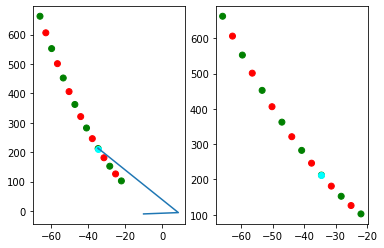

Distance to the closest point : 9.688472847502764e-05 which is a Minimum


In [ ]:
testbfgs([-10, -10], "exact")

We see that with the point (-10, 10) we converge really fast to a stationary point which is a minimzer ! Let's try 5 others points to see if we always converge

x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  10


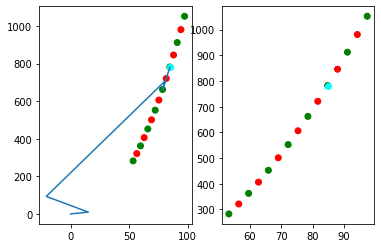

Distance to the closest point : 8.100624226164232e-07 which is a Minimum

x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  5


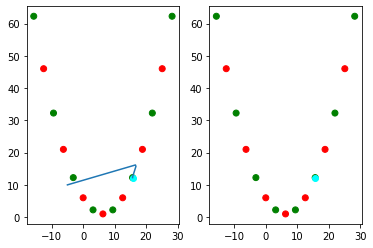

Distance to the closest point : 9.759254833575245e-11 which is a Minimum

x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  5


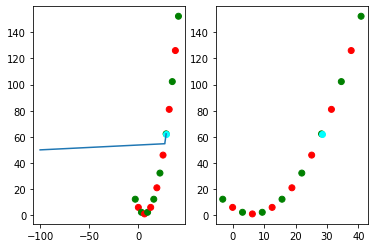

Distance to the closest point : 2.1180371903100848e-08 which is a Minimum

x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  9


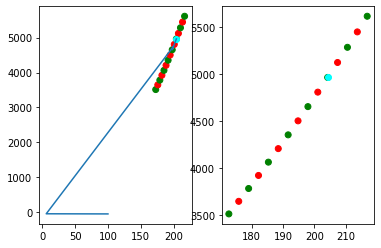

Distance to the closest point : 2.776117533064454e-06 which is a Minimum

x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  6


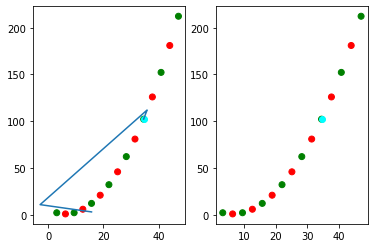

Distance to the closest point : 6.358871293280124e-10 which is a Minimum

x0 :  [-1000, 1000]
Stopping criteria reached !
 Iterations :  11


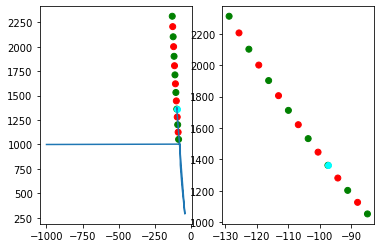

Distance to the closest point : 4.0971986123774135e-09 which is a Minimum



In [ ]:
x0 = [[0,0], [-5, 10], [-100, 50], [100, -50], [np.pi/2*10, np.pi], [-1000, 1000]]
for x in x0:
    print("x0 : ", x)
    testbfgs(x, "exact")
    print()

We can see that all from all of these initial conditions, even really far from the solutions, we converge really fast to a global minimum. This shows the efficacity of the bfgs method with exact line search.
Let's now see what happens with the pure BFGS method (with the step equal to 1).





x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  23


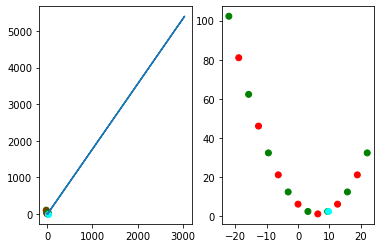

Distance to the closest point : 3.9202633911273506e-07 which is a Minimum

x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  12


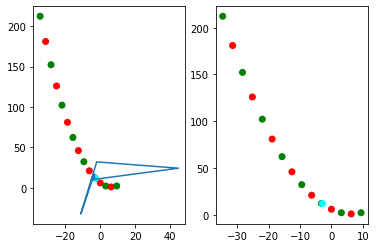

Distance to the closest point : 6.391903705683985e-08 which is a Minimum

x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  26


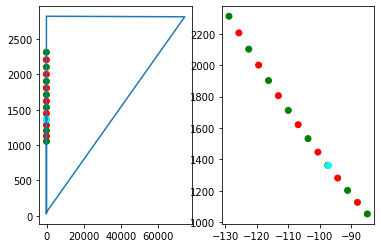

Distance to the closest point : 2.178943039672939e-07 which is a Minimum

x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  26


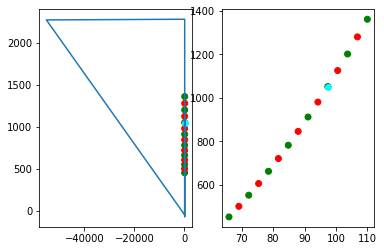

Distance to the closest point : 3.116074695415528e-07 which is a Minimum

x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  11


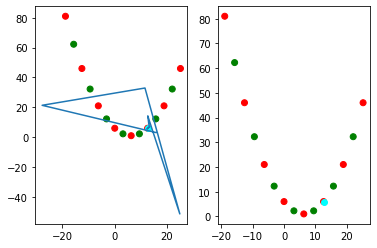

Distance to the closest point : 4.968560490864217e-07 which is a Saddle point

x0 :  [-1000, 1000]
The sequence diverged



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
for x in x0:
    print("x0 : ", x)
    testbfgs(x, "const")
    print()

We can see that the pure bfgs method is less efficient than the one with exact line search. The convergence is not more assured (it can even diverge when we are really far), and we can also converge to saddle points.
In this method, we used the stopping criteria $|\nabla f(x_k) < \epsilon|$.
Let's compare this stopping criteria with the criterias $|f(x_k) - f(x_{k-1})| < \epsilon $ and $d(x_k, x_{k-1}) < \epsilon$.
 


In [ ]:
for x in x0 :
    print("x0 : ", x)
    checkStopCrit(x, lambda x, crit : bfgs(f1, x, 1e-7, 3000, "const", crit))
    print()

x0 :  [0, 0]
########Criteria :  grad
Stopping criteria reached !
 Iterations :  24
Solution obtained :  [9.42477796 2.25      ]
Distance to the closest point : 8.232572540813215e-10 which is a Minimum

########Criteria :  closeF
Stopping criteria reached !
 Iterations :  23
Solution obtained :  [9.42477793 2.25000039]
Distance to the closest point : 3.9202633911273506e-07 which is a Minimum

########Criteria :  closeX
Stopping criteria reached !
 Iterations :  25
Solution obtained :  [9.42477796 2.25      ]
Distance to the closest point : 5.465896178762675e-12 which is a Minimum


x0 :  [-5, 10]
########Criteria :  grad
Stopping criteria reached !
 Iterations :  13
Solution obtained :  [-3.14159265 12.25      ]
Distance to the closest point : 1.1646235358281364e-09 which is a Minimum

########Criteria :  closeF
Stopping criteria reached !
 Iterations :  12
Solution obtained :  [-3.14159263 12.25000006]
Distance to the closest point : 6.391903705683985e-08 which is a Minimum

########C

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


Solution obtained :  [nan nan]
The sequence diverged

########Criteria :  closeF
Stopping criteria reached !
 Iterations :  4
Solution obtained :  [  -999.99225581 128247.05503941]
Distance to the closest point : 246.05693482362747 which is a Saddle point

########Criteria :  closeX
Stopping criteria reached !
 Iterations :  5
Solution obtained :  [  -999.99225581 128247.05503942]
Distance to the closest point : 246.05693482755646 which is a Saddle point




We see there that for a fixed $\epsilon$, the most accurate stopping criteria (which gives us an x the closest to the stationnary point) is $d(x_k, x_{k-1}) < \epsilon$. Having a small gradient is also acceptable, and finally the criteria of having $d(f(x_k), f_(x_{k+1})) < \epsilon$ can be sometimes irrelevant, for example here with $x_0 = (-100, 50)$, where we obtain a result pretty far from the closest stationnary point, where the others methods go really closer to it. 

Let's now try this with the steepest descent method and exact line search

Stopping criteria reached !
 Iterations :  819


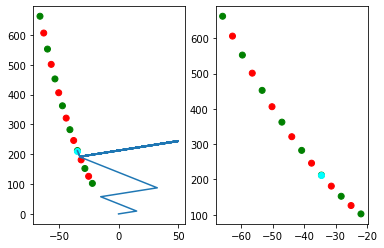

Distance to the closest point : 0.00011068968907281428 which is a Minimum


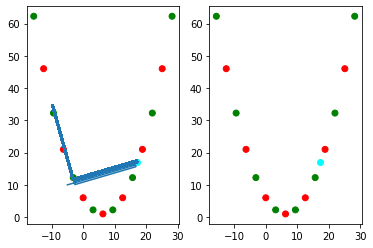

Distance to the closest point : 4.344820402571607 which is a Saddle point


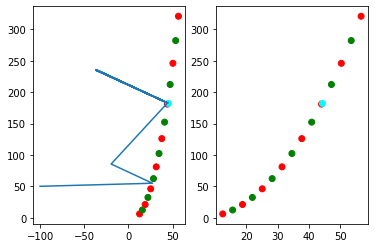

Distance to the closest point : 1.8313882792807528 which is a Saddle point


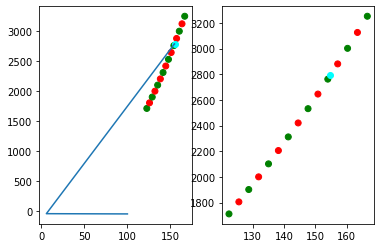

Distance to the closest point : 28.598580670975284 which is a Minimum


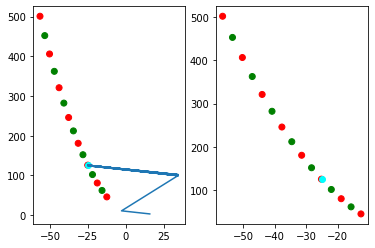

Distance to the closest point : 0.1870534281611741 which is a Saddle point


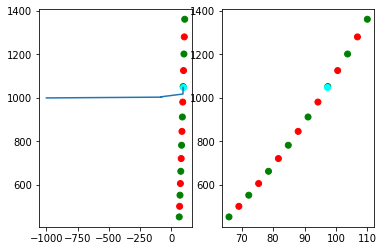

Distance to the closest point : 3.897075594149955 which is a Minimum


In [ ]:
for x in x0:
    testSteepestExact(x)

We can see there that the steepest descent method with exact line search does not converge as good as the bfgs method (recall that the steepest descent method with exact line search should always converge to a stationnary point). 
To begin with, it converges sometimes to saddle points, so it's not at 100% efficient to find minimizers.
Moreover, the convergence is sometimes really slow. We can see with the backtracking of the points of the descent that the Zig Zag theorem is verified, which can lead to a really slow convergence, and that's what we have right now.
Let's compare the efficiency of different stopping criteria in this method (With the gradient criteria, we most of the time are stopped by the maximal iteration)

In [ ]:
for x in x0 :
    print("x0 : ", x)
    checkStopCrit(x, lambda x, crit : gradientExact(f1, x, 1e-6, 3000, "exact", crit))
    print()

x0 :  [0, 0]
########Criteria :  grad
Stopping criteria reached !
 Iterations :  857
Solution obtained :  [-34.55751815 212.24998875]
Distance to the closest point : 1.1295369489279707e-05 which is a Minimum

########Criteria :  closeF
Stopping criteria reached !
 Iterations :  627
Solution obtained :  [-34.55558767 212.22912292]
Distance to the closest point : 0.02096624056624546 which is a Minimum

########Criteria :  closeX
Stopping criteria reached !
 Iterations :  779
Solution obtained :  [-34.55748927 212.24967658]
Distance to the closest point : 0.0003248056808431559 which is a Minimum


x0 :  [-5, 10]
########Criteria :  grad
Solution obtained :  [-3.3666562  11.78306883]
Distance to the closest point : 0.5183418887153393 which is a Minimum

########Criteria :  closeF
Solution obtained :  [-3.3666562  11.78306883]
Distance to the closest point : 0.5183418887153393 which is a Minimum

########Criteria :  closeX
Solution obtained :  [-3.3666562  11.78306883]
Distance to the close

For the steepest descent method with exact line search, the slow convergence makes the close X stopping criteria not as well as the bfgs method. For this one, it's better to chose a stopping criteria related to the gradient of f.

c) Let's now try the SR1 method.

We will try this with different initial matrixes b0

b0 : 
 [[1. 0.]
 [0. 1.]]
x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  9


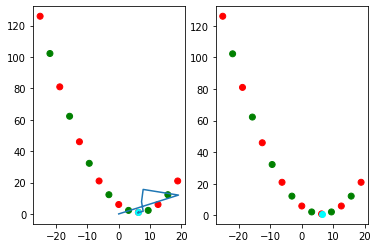

Distance to the closest point : 1.7591752038183323e-10 which is a Saddle point
x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  10


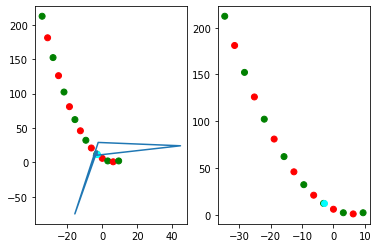

Distance to the closest point : 1.380228121126752e-12 which is a Minimum
x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  10


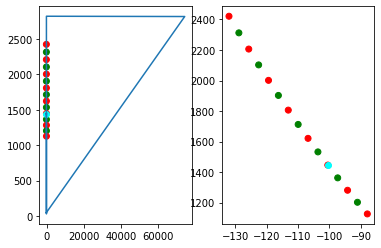

Distance to the closest point : 6.513143053850983e-08 which is a Saddle point
x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  10


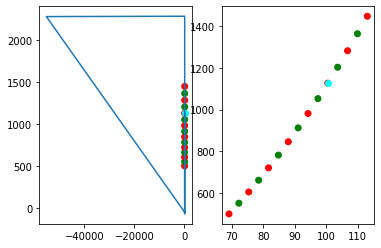

Distance to the closest point : 7.133972704429434e-08 which is a Saddle point
x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  11


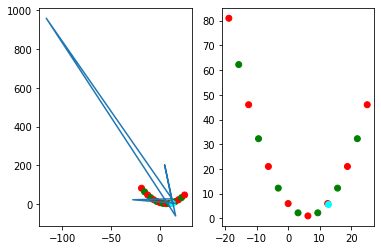

Distance to the closest point : 8.187090987657263e-08 which is a Saddle point
x0 :  [-1000, 1000]
Stopping criteria reached !
 Iterations :  12


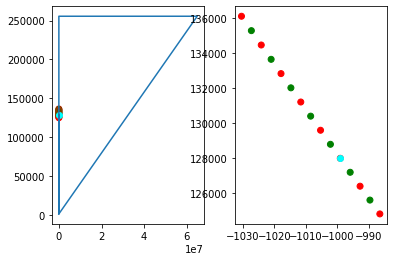

Distance to the closest point : 3.2931233409893805e-08 which is a Saddle point
b0 : 
 [[5 4]
 [4 2]]
x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  6


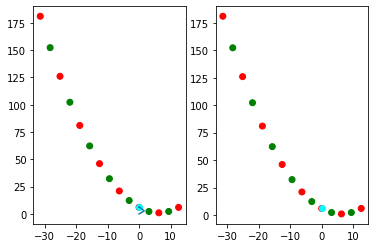

Distance to the closest point : 3.04298883612601e-09 which is a Saddle point
x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  11


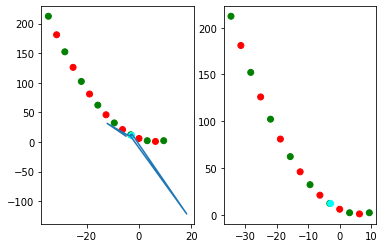

Distance to the closest point : 5.2802122827289615e-12 which is a Minimum
x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  8


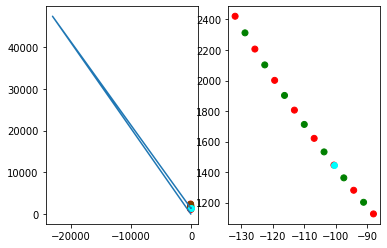

Distance to the closest point : 1.0357004194978697e-07 which is a Saddle point
x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  8


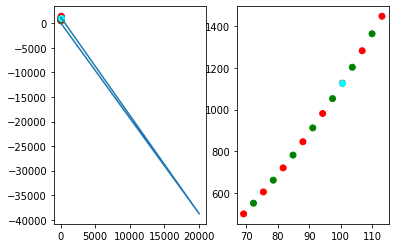

Distance to the closest point : 1.1143253612031366e-07 which is a Saddle point
x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  7


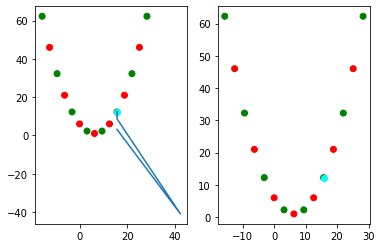

Distance to the closest point : 1.869742370921054e-10 which is a Minimum
x0 :  [-1000, 1000]
Stopping criteria reached !
 Iterations :  19


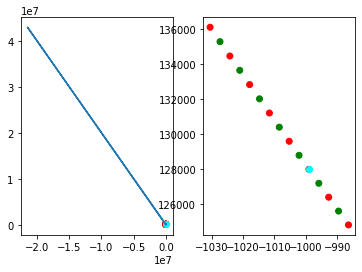

Distance to the closest point : 2.3283200367310267e-10 which is a Saddle point
b0 : 
 [[12 -6]
 [-6  5]]
x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  9


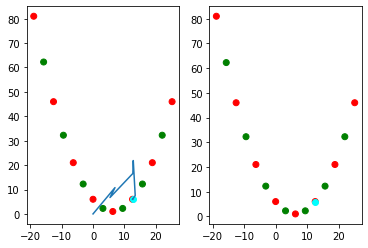

Distance to the closest point : 5.76555353149484e-09 which is a Saddle point
x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  13


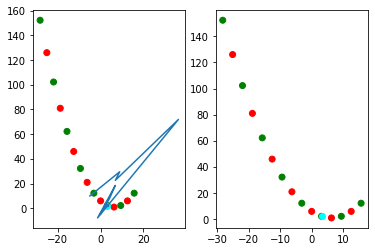

Distance to the closest point : 6.325465303857876e-08 which is a Minimum
x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  11


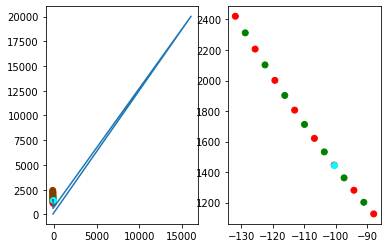

Distance to the closest point : 6.412460108192323e-10 which is a Saddle point
x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  11


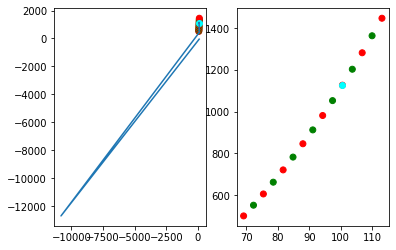

Distance to the closest point : 6.0390905431980875e-09 which is a Saddle point
x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  7


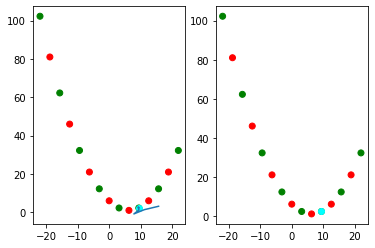

Distance to the closest point : 1.2973405235696188e-08 which is a Minimum
x0 :  [-1000, 1000]
Stopping criteria reached !
 Iterations :  11


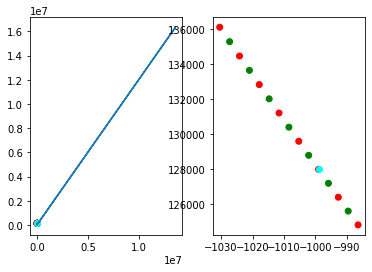

Distance to the closest point : 2.753243233532002e-08 which is a Saddle point
b0 : 
 [[-1. -0.]
 [-0. -1.]]
x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  11


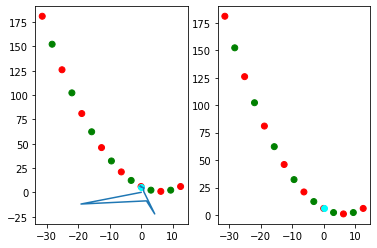

Distance to the closest point : 5.677805650768618e-12 which is a Saddle point
x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  11


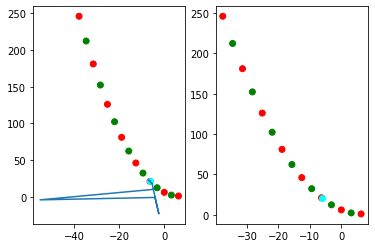

Distance to the closest point : 3.1484260868852843e-09 which is a Saddle point
x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  10


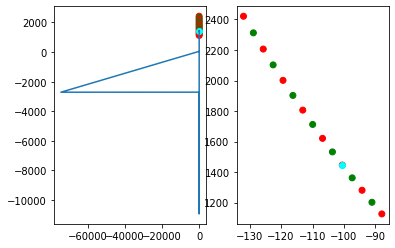

Distance to the closest point : 5.598652874580767e-09 which is a Saddle point
x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  10


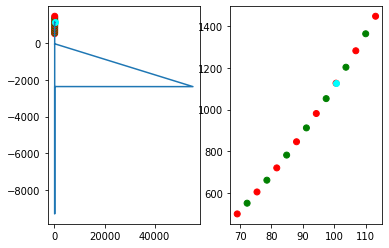

Distance to the closest point : 5.091897299044113e-09 which is a Saddle point
x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  10


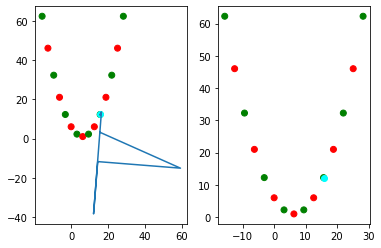

Distance to the closest point : 2.9175997318585744e-10 which is a Minimum
x0 :  [-1000, 1000]
Stopping criteria reached !
 Iterations :  12


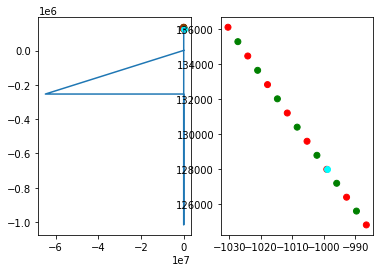

Distance to the closest point : 3.559425399221095e-08 which is a Saddle point
b0 : 
 [[  5   5]
 [  5 -10]]
x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  6


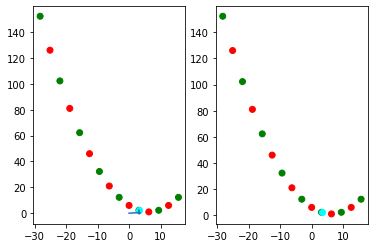

Distance to the closest point : 3.7474981024026164e-10 which is a Minimum
x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  9


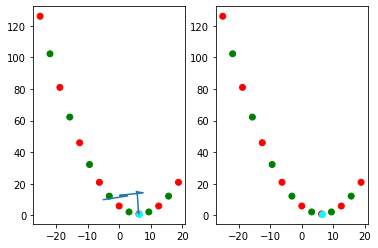

Distance to the closest point : 2.944959052618672e-08 which is a Saddle point
x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  11


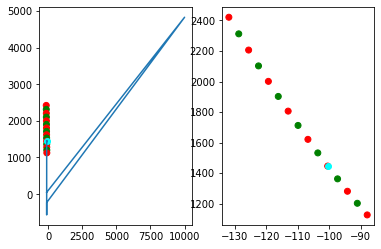

Distance to the closest point : 4.7325007168962765e-08 which is a Saddle point
x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  12


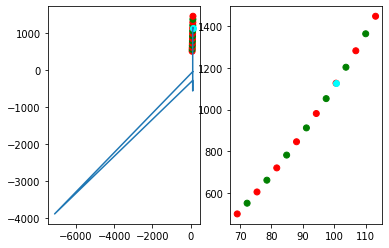

Distance to the closest point : 1.6711724903172296e-09 which is a Saddle point
x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  11


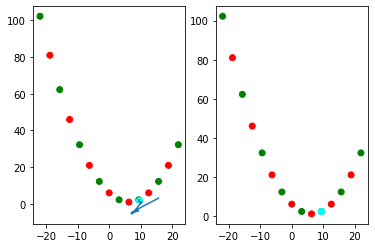

Distance to the closest point : 1.6439561204031786e-09 which is a Minimum
x0 :  [-1000, 1000]
Stopping criteria reached !
 Iterations :  12


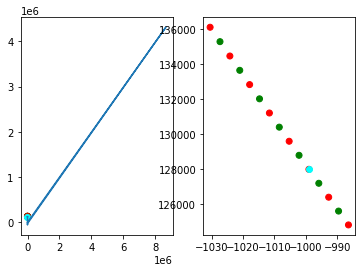

Distance to the closest point : 1.1368683772161603e-13 which is a Saddle point


In [ ]:
b0 = []
b0.append(np.eye(2))
b0.append(np.array([[5, 4], [4, 2]]))
b0.append(np.array([[12, -6], [-6, 5]]))
b0.append(-np.eye(2))
b0.append(np.array([[5,5], [5,-10]])) 

for b in b0:
    print("b0 : \n", b)
    for x in x0:
        print("x0 : ", x)
        testSR1(x, 0, b, "const")

We can see that the SR1 method converges even if we are far from the initial solution, but we often fall on saddle points.
Let's see if it's better with an exact line search.


x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  11


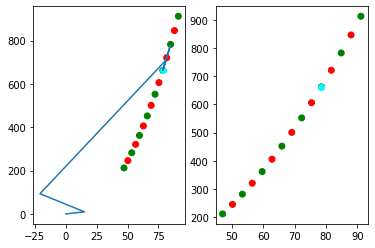

Distance to the closest point : 1.293550687758101e-09 which is a Minimum
x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  5


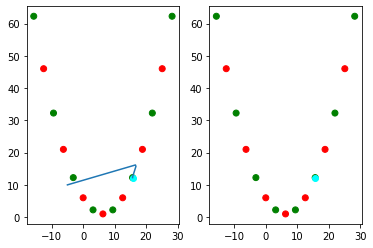

Distance to the closest point : 2.4181325452315665e-11 which is a Minimum
x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  5


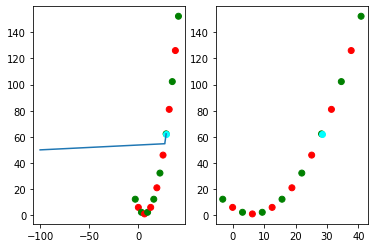

Distance to the closest point : 7.680428220939982e-09 which is a Minimum
x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  10


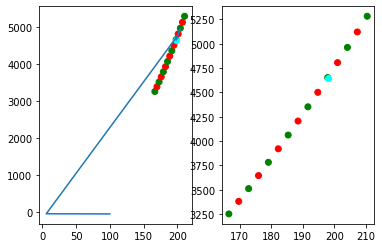

Distance to the closest point : 1.7549183411023068e-08 which is a Minimum
x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  6


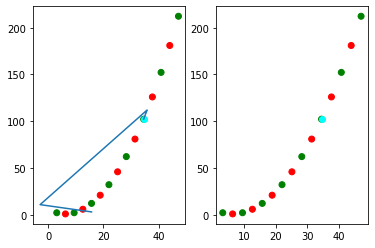

Distance to the closest point : 4.861683882918903e-10 which is a Minimum
x0 :  [-1000, 1000]
Stopping criteria reached !
 Iterations :  5


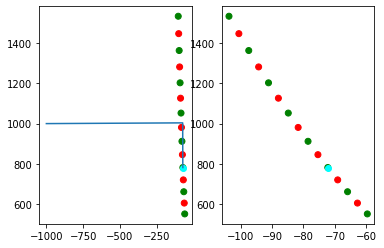

Distance to the closest point : 5.019525334652884e-09 which is a Minimum


In [ ]:
b = np.eye(2)
for x in x0: 
    print("x0 : ", x)
    testSR1(x,0,b,  "exact")

We see there that we can improve the SR1 method by using an exact line search, with this one we converge more often to minimizers.
Let's compare now the stopping criterias

In [ ]:
for x in x0 :
    print("x0 : ", x)
    checkStopCrit(x, lambda x, crit : SR1(f1, x, 1e-7, 3000, np.eye(2), 0,  "const", crit))
    print()

x0 :  [0, 0]
########Criteria :  grad
Stopping criteria reached !
 Iterations :  9
Solution obtained :  [6.28318531 1.        ]
Distance to the closest point : 1.7591752038183323e-10 which is a Saddle point

########Criteria :  closeF
Stopping criteria reached !
 Iterations :  9
Solution obtained :  [6.28318531 1.        ]
Distance to the closest point : 1.7591752038183323e-10 which is a Saddle point

########Criteria :  closeX
Stopping criteria reached !
 Iterations :  10
Solution obtained :  [6.28318531 1.        ]
Distance to the closest point : 5.29309815580535e-15 which is a Saddle point


x0 :  [-5, 10]
########Criteria :  grad
Stopping criteria reached !
 Iterations :  10
Solution obtained :  [-3.14159265 12.25      ]
Distance to the closest point : 1.380228121126752e-12 which is a Minimum

########Criteria :  closeF
Stopping criteria reached !
 Iterations :  9
Solution obtained :  [-3.14159273 12.25000007]
Distance to the closest point : 1.075987067041024e-07 which is a Minimum

For this method, taking the gradient stopping criteria is a good compromize, because as we see for the point (-1000,1000), the algorithm stops close to a stationnary point, when for the closeX method, it stops really far of it.

d)Let's now check the convergence rate of our methods

In [ ]:
def convRateBFGS(x0):
    x, x_tab = bfgs(f1, x0, 1e-7, 10000)
    checkConvRate(x_tab, 5)

for x in x0:
    print("x0 : ", x)
    convRateBFGS(x)
    print()

x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  24
21th iteration :  2.1225715723916054
22th iteration :  0.5596395133034955
23th iteration :  1.7264972710781883
24th iteration :  1.1736229006937986
25th iteration :  1.490530529329046
Mean of the rates :  1.4145723573592268
Median of the rates :  1.490530529329046

x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  13
10th iteration :  4.63013893236881
11th iteration :  1.5540398699496518
12th iteration :  1.3855298422103528
13th iteration :  1.1759270961949342
14th iteration :  0.8086476506610336
Mean of the rates :  1.9108566782769565
Median of the rates :  1.3855298422103528

x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  27
24th iteration :  1.4391319493541541
25th iteration :  2.2460284317824355
26th iteration :  1.1505435555565975
27th iteration :  0.4839229221215005
28th iteration :  1.8689387735318812
Mean of the rates :  1.437713126469314
Median of the rates :  1.4391319493541541

x0 :  [100, -50]
S

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


The sequence has diverged



When bfgs converges (which happens really fast), the convergence is superlinear, with a convergence rate around 1.5

Let's now look at the steepest descent method

In [ ]:
#Steepest descent

def convRateGradient(x0, step):
    x, x_tab = gradientExact(f1, x0, 1e-6, 1000, step)
    checkConvRate(x_tab, 5)

for x in x0:
    print("x0 : ", x)
    convRateGradient(x, "exact")
    print()

x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  857
854th iteration :  0.08931194044776207
855th iteration :  10.180895162346824
856th iteration :  0.09816628082605049
857th iteration :  11.678432406263198
858th iteration :  0.07729596258488101
Mean of the rates :  4.424820350493743
Median of the rates :  0.09816628082605049

x0 :  [-5, 10]
996th iteration :  -126.34438038089141
997th iteration :  0.1625696825978983
998th iteration :  0.0448379151275472
999th iteration :  -21.310895617983682
1000th iteration :  6.479947715352573
Mean of the rates :  -28.193584137159412
Median of the rates :  0.0448379151275472

x0 :  [-100, 50]
996th iteration :  -0.0007719035532136836
997th iteration :  1294.470911869038
998th iteration :  -4.698137055972045e-07
999th iteration :  2135882.0338594965
1000th iteration :  -0.0007699410783869685
Mean of the rates :  427435.3006458102
Median of the rates :  -4.698137055972045e-07

x0 :  [100, -50]
996th iteration :  31.143835882600623
997th iterati

We can see that the convergence rate of the steepest descent method is weird, it's even sometimes negative.
In theory it should be equal to 1, but because of the zig-zag theorem, we are computing distances on really close points, and we can obtain numerical errors, which gives this convergence rate.
Let's check what happens with the Armijo rule.


In [ ]:
for x in x0:
    print("x0 : ", x)
    convRateGradient(x, "armijo")
    print()

x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  42
39th iteration :  1.8736868824314898
40th iteration :  0.5960144553967238
41th iteration :  1.406893358848536
42th iteration :  0.8652050157241497
43th iteration :  0.7679819844750452
Mean of the rates :  1.101956339375189
Median of the rates :  0.8652050157241497

x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  153
150th iteration :  0.2770617153385072
151th iteration :  1.690187486797775
152th iteration :  0.5625030152010277
153th iteration :  1.8077633950827983
154th iteration :  0.5345450107808443
Mean of the rates :  0.9744121246401904
Median of the rates :  0.5625030152010277

x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  652
649th iteration :  1.9524242695830014
650th iteration :  0.9927822202832574
651th iteration :  0.5164551924329153
652th iteration :  1.950074638664508
653th iteration :  0.5033912224076025
Mean of the rates :  1.1830255086742567
Median of the rates :  0.9927822202832574

x0 : 

We can see that with the Armijo backtracking we find a convergence rate much more coherent which is closer to 1 than before. (So we have a linear convergence)

Let's now look at the SR1 method

In [ ]:
def convRateSR1(x0):
    x, x_tab = SR1(f1, x0, 1e-9, 2000, np.eye(2), 0 , "const")
    checkConvRate(x_tab, 5)

for x in x0:
    print("x0 : ", x)
    convRateSR1(x)
    print()

x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  9
6th iteration :  0.9598834355032716
7th iteration :  2.1673131196545365
8th iteration :  0.5099187709221962
9th iteration :  4.711636944033125
10th iteration :  1.3346437749053173
Mean of the rates :  1.9366792090036893
Median of the rates :  1.3346437749053173

x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  10
7th iteration :  0.01600635727238786
8th iteration :  192.11604826771057
9th iteration :  1.1677970069459231
10th iteration :  0.6704226719448704
11th iteration :  2.9101161009668046
Mean of the rates :  39.37607808096811
Median of the rates :  1.1677970069459231

x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  11
8th iteration :  1.629636193001394
9th iteration :  1.2124774711930753
10th iteration :  0.94430827465029
11th iteration :  1.792073787245528
12th iteration :  1.6117491247708293
Mean of the rates :  1.4380489701722232
Median of the rates :  1.6117491247708293

x0 :  [100, -50]
Stopping cr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:232: RuntimeWarning: divide by zero encountered in log


Since this this method converges really fast we can have some suprising rates, but generally we have the same 1.5 superlinear convergence than the fgs method

e) Let's convert ur methods into inexact line search strategies

1) Bfgs with armijo backtracking : We can modify the bfgs method to put armijo backtracking. There are the results we obtain :

x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  7


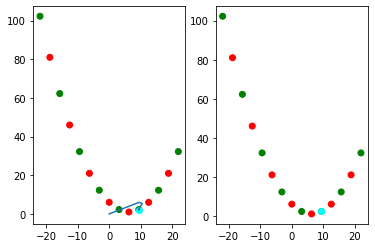

Distance to the closest point : 6.403359803583828e-07 which is a Minimum

x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  7


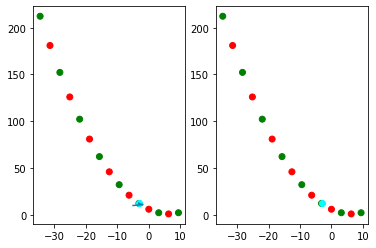

Distance to the closest point : 4.5194485990621245e-08 which is a Minimum

x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  12


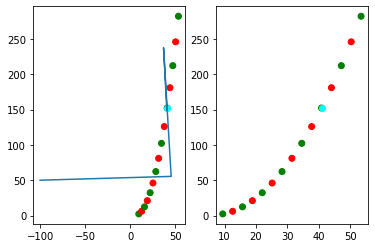

Distance to the closest point : 2.9643085017579685e-07 which is a Minimum

x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  11


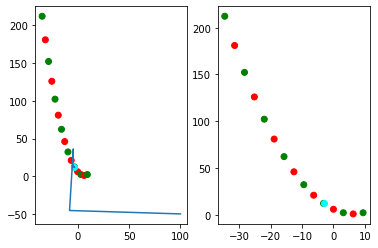

Distance to the closest point : 1.4283942203125278e-06 which is a Minimum

x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  5


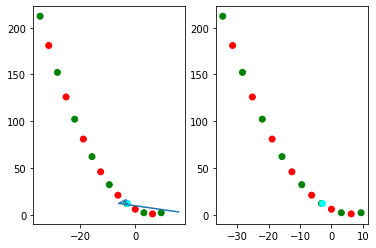

Distance to the closest point : 4.845689069256294e-06 which is a Minimum

x0 :  [-1000, 1000]
Stopping criteria reached !
 Iterations :  15


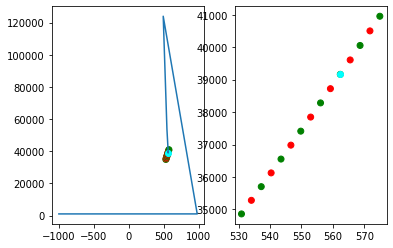

Distance to the closest point : 2.929374657257322e-08 which is a Minimum



In [ ]:
for x in x0:
    print("x0 : ", x)
    testbfgs(x, "armijo")
    print()

We can see there that the Armijo backtracking improves the convergence to global minimizers, even far of the solutions. 

There is now the steepest descent method, with some different values of $\alpha$


alpha =  0.001
x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  8503


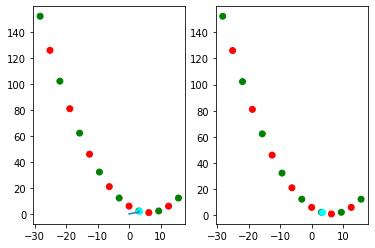

Distance to the closest point : 5.800116497211315e-07 which is a Minimum

x0 :  [-5, 10]


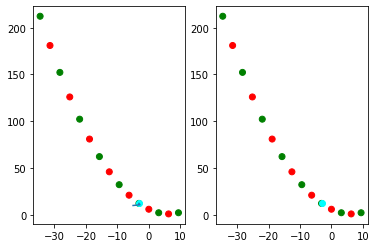

Distance to the closest point : 0.00029132736623365286 which is a Minimum

x0 :  [-100, 50]


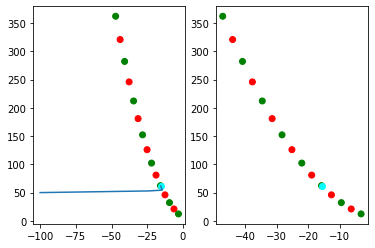

Distance to the closest point : 0.615998110856509 which is a Minimum

x0 :  [100, -50]


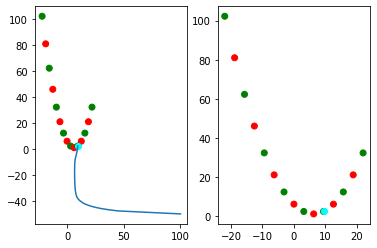

Distance to the closest point : 1.2769690531786849e-06 which is a Minimum

x0 :  [15.707963267948966, 3.141592653589793]


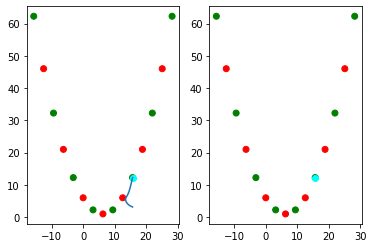

Distance to the closest point : 0.0016908309453505701 which is a Minimum

x0 :  [-1000, 1000]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in cos
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sin


The sequence diverged

alpha =  0.01
x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  842


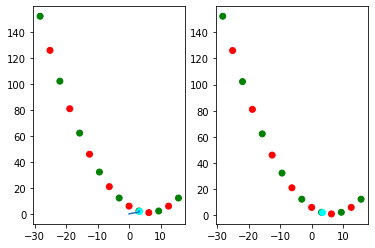

Distance to the closest point : 5.748832979938468e-07 which is a Minimum

x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  1630


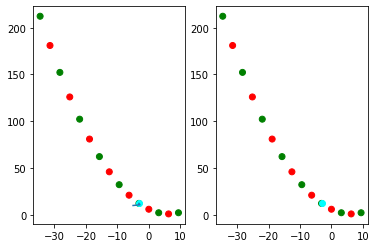

Distance to the closest point : 1.1487693679099936e-06 which is a Minimum

x0 :  [-100, 50]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in cos
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sin


The sequence diverged

x0 :  [100, -50]
The sequence diverged

x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  1834


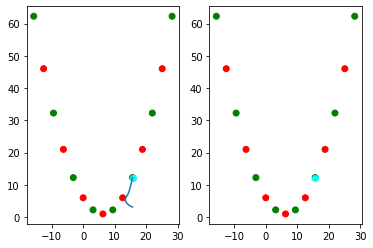

Distance to the closest point : 1.1495356053118505e-06 which is a Minimum

x0 :  [-1000, 1000]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in cos
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sin


The sequence diverged

alpha =  0.1
x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  75


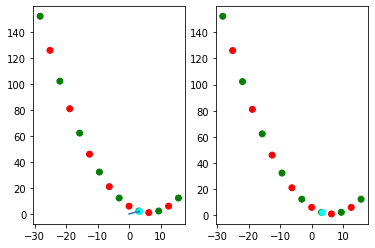

Distance to the closest point : 5.18309054016688e-07 which is a Minimum

x0 :  [-5, 10]


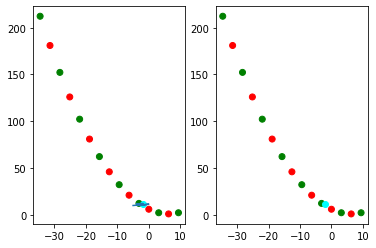

Distance to the closest point : 1.21394426717307 which is a Minimum

x0 :  [-100, 50]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in cos
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sin


The sequence diverged

x0 :  [100, -50]
The sequence diverged

x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  83


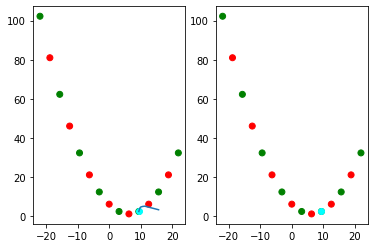

Distance to the closest point : 5.500877397978051e-07 which is a Minimum

x0 :  [-1000, 1000]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in cos
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sin


The sequence diverged

alpha =  0.5
x0 :  [0, 0]
The sequence diverged

x0 :  [-5, 10]
The sequence diverged

x0 :  [-100, 50]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars


The sequence diverged

x0 :  [100, -50]
The sequence diverged

x0 :  [15.707963267948966, 3.141592653589793]
The sequence diverged

x0 :  [-1000, 1000]
The sequence diverged



In [ ]:
alphas = [0.001, 0.01, 0.1, 0.5]

for alpha in alphas :
    print("alpha = ", alpha)
    for x in x0:
        print("x0 : ", x)
        testSteepestConstant(x, alpha)
        print()


We can see that the convergence depends on the distance of $x_0$ to the solutions, and also of the value of $\alpha$.
In fact, we can prove that we have a convergence to a stationnary point if $$\alpha < \frac{2}{L}$$, with $L$ the lipschitz constant of $\nabla f$. Si f is infinitely differentiable, $\nabla F$ is locally lipschitz, and has some constant $L$ on some neighbordhood of the stationnary points. If we take an $\alpha$ smaller than this $\frac{2}{L}$ and an initial condition in this neighborhood, the descent will converge, and sometimes faster than with the exact line search since it doesn't do always a zig zag. But if we take an $x_0$ so far to the stationnary point that $\nabla f$ is not $L$ lipshitz anymore, the descent will not converge anymore. We'll have then to find a new Lipschitz constant (bigger than L) that makes the descent converge. (The proof of this is based to the Banach Fixed Point theroem).

By the way, it's a bit off-topic but we spoke before about the convergence rate of the steepest descent method but we didn't show how this method converges. Here it is :
 

x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  36


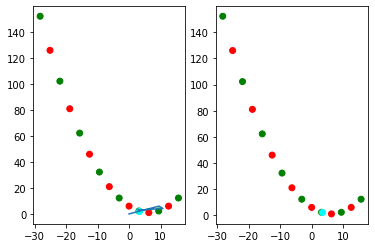

Distance to the closest point : 2.959258418070737e-06 which is a Minimum

x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  128


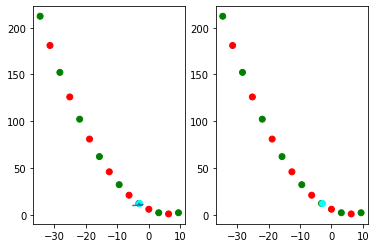

Distance to the closest point : 7.159086475109302e-06 which is a Minimum

x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  560


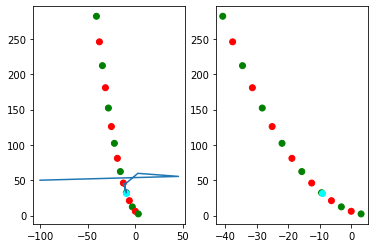

Distance to the closest point : 1.49669786627257e-05 which is a Minimum

x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  983


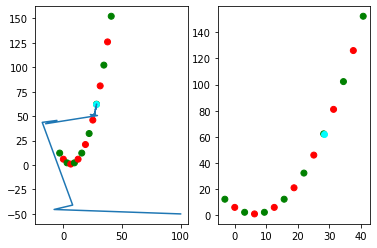

Distance to the closest point : 3.2836427464752663e-05 which is a Minimum

x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  156


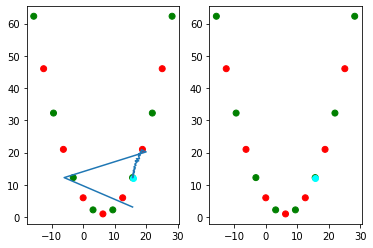

Distance to the closest point : 6.858035237268765e-06 which is a Minimum

x0 :  [-1000, 1000]


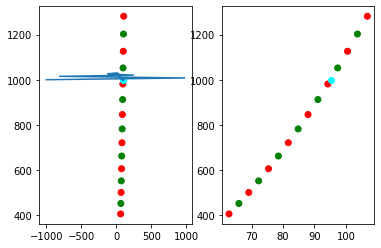

Distance to the closest point : 19.584669940865158 which is a Saddle point



In [ ]:
for x in x0:
    print("x0 : ", x)
    x, x_tab = gradientExact(f1, x, 1e-5, 4000, "armijo")
    evalDescentLim(x_tab, True)
    print()  

We can see that except for the last point (-1000,1000), we have a faast convergence to global minimum with the steepest descent method and the armijo rule.

Let's now try to modify the SR1 method by adding $\gamma I$ to $H_k$ before determining the new search directions.

gamma :  0.1
x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  9


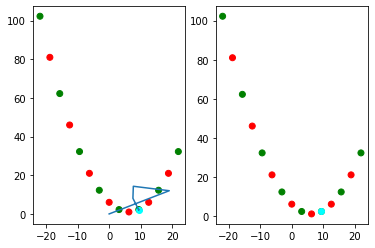

Distance to the closest point : 3.132097593417916e-08 which is a Minimum

x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  11


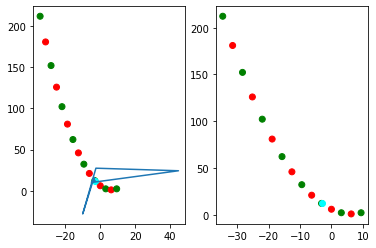

Distance to the closest point : 5.138202747428114e-07 which is a Minimum

x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  17


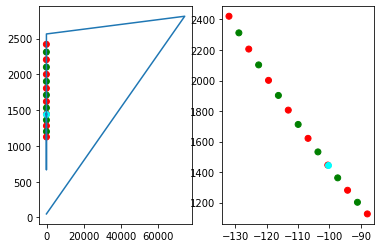

Distance to the closest point : 5.483532527536664e-08 which is a Saddle point

x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  17


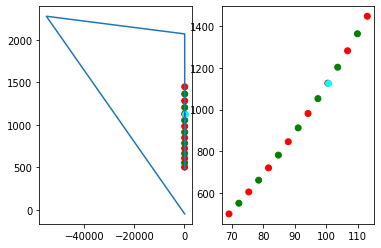

Distance to the closest point : 2.456822861224767e-08 which is a Saddle point

x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  12


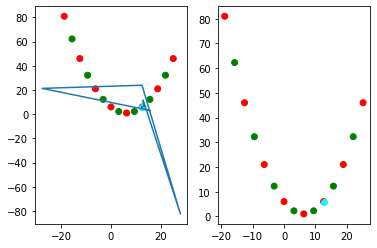

Distance to the closest point : 9.394420420737158e-08 which is a Saddle point

x0 :  [-1000, 1000]
Stopping criteria reached !
 Iterations :  23


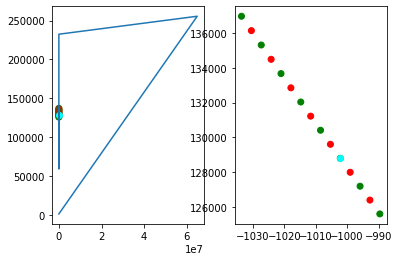

Distance to the closest point : 1.0378505789205016e-07 which is a Minimum


gamma :  0.5
x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  13


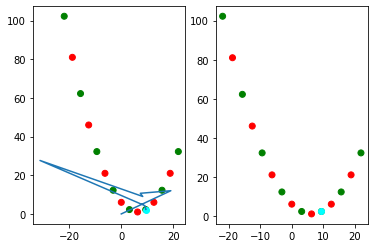

Distance to the closest point : 1.6165975248457792e-07 which is a Minimum

x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  11


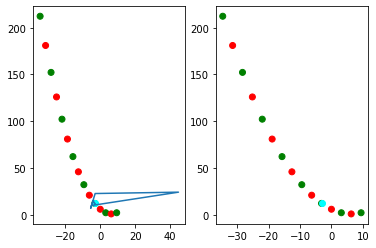

Distance to the closest point : 2.0944386733851015e-07 which is a Minimum

x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  26


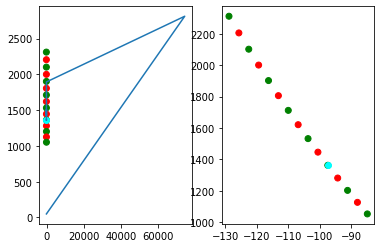

Distance to the closest point : 7.2344630508755814e-09 which is a Minimum

x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  20


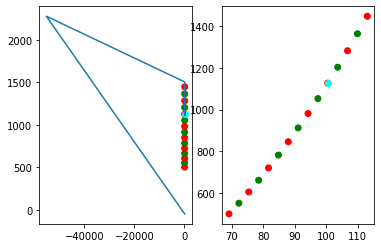

Distance to the closest point : 2.279525582065272e-07 which is a Saddle point

x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  15


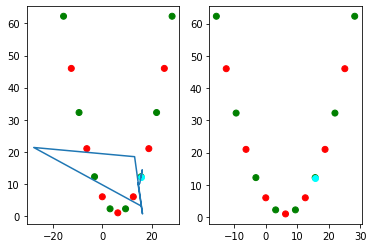

Distance to the closest point : 6.550881782399358e-08 which is a Minimum

x0 :  [-1000, 1000]
Stopping criteria reached !
 Iterations :  39


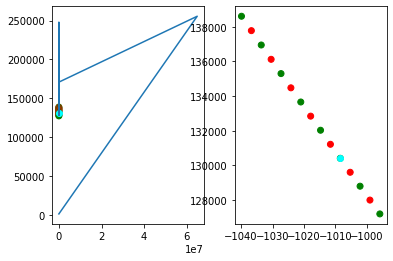

Distance to the closest point : 1.2473996591104473e-07 which is a Minimum


gamma :  1
x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  23


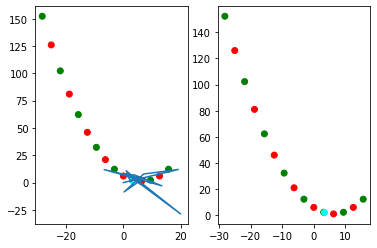

Distance to the closest point : 6.482581513609786e-08 which is a Minimum

x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  13


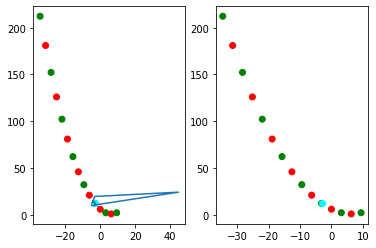

Distance to the closest point : 6.031847476037307e-08 which is a Minimum

x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  16


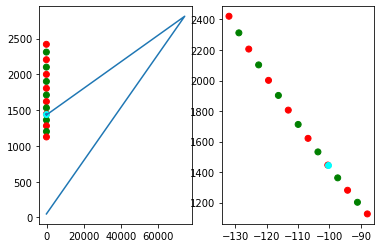

Distance to the closest point : 5.165743972911926e-09 which is a Saddle point

x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  16


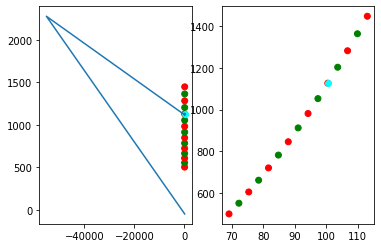

Distance to the closest point : 2.5606516082456054e-10 which is a Saddle point

x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  16


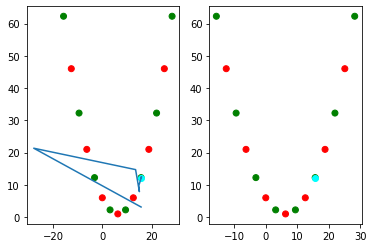

Distance to the closest point : 9.563081036155363e-08 which is a Minimum

x0 :  [-1000, 1000]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in true_divide


The sequence diverged


gamma :  2
x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  55


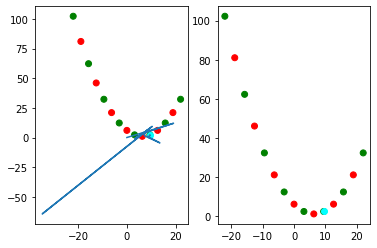

Distance to the closest point : 5.62718646565902e-08 which is a Minimum

x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  15


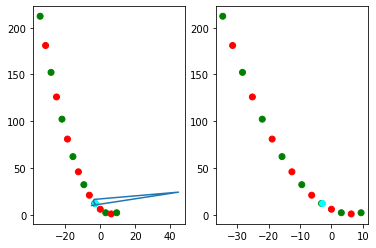

Distance to the closest point : 1.7489744877234224e-07 which is a Minimum

x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  22


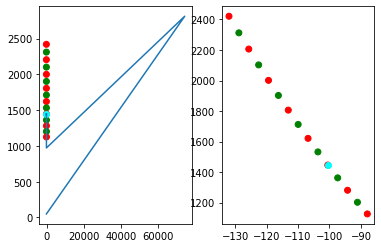

Distance to the closest point : 9.153192825093887e-09 which is a Saddle point

x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  19


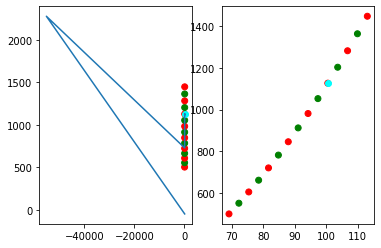

Distance to the closest point : 1.1280207373227013e-08 which is a Saddle point

x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  14


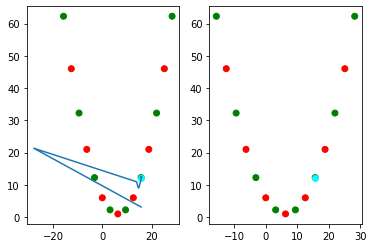

Distance to the closest point : 6.592944271665697e-08 which is a Minimum

x0 :  [-1000, 1000]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in true_divide


The sequence diverged


gamma :  5
x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  28


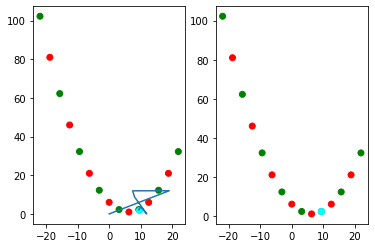

Distance to the closest point : 3.420639907307031e-07 which is a Minimum

x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  25


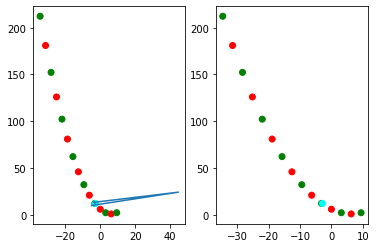

Distance to the closest point : 7.565546320475994e-08 which is a Minimum

x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  29


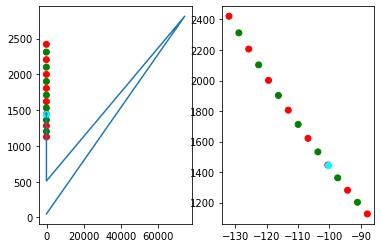

Distance to the closest point : 7.61640986120647e-09 which is a Saddle point

x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  29


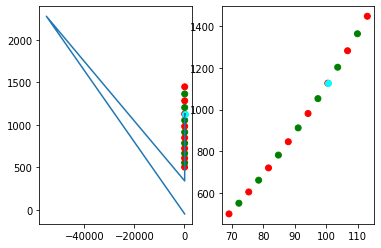

Distance to the closest point : 2.6807209980528487e-08 which is a Saddle point

x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  28


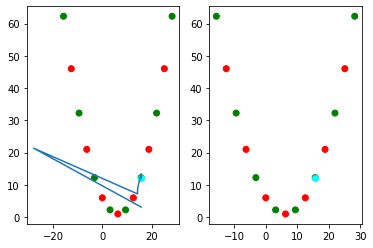

Distance to the closest point : 4.996221504595653e-07 which is a Minimum

x0 :  [-1000, 1000]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in true_divide


The sequence diverged


gamma :  10
x0 :  [0, 0]
Stopping criteria reached !
 Iterations :  76


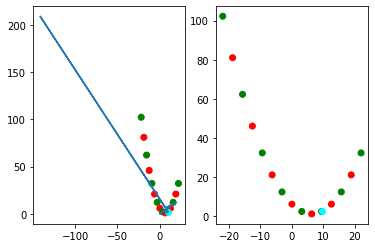

Distance to the closest point : 3.130360648327117e-07 which is a Minimum

x0 :  [-5, 10]
Stopping criteria reached !
 Iterations :  42


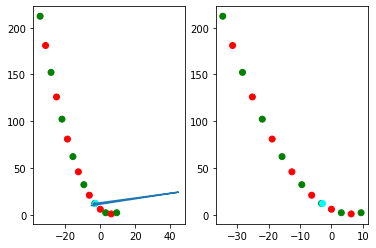

Distance to the closest point : 4.5286647369872174e-07 which is a Minimum

x0 :  [-100, 50]
Stopping criteria reached !
 Iterations :  37


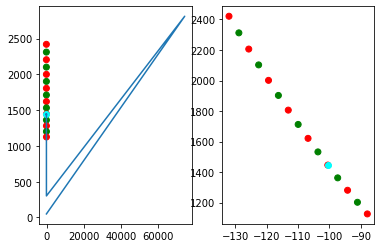

Distance to the closest point : 4.785585181996016e-08 which is a Saddle point

x0 :  [100, -50]
Stopping criteria reached !
 Iterations :  36


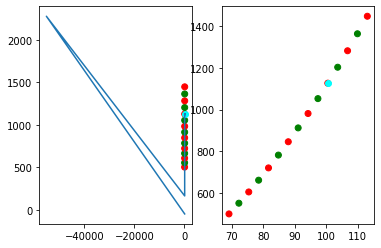

Distance to the closest point : 1.239491757072703e-07 which is a Saddle point

x0 :  [15.707963267948966, 3.141592653589793]
Stopping criteria reached !
 Iterations :  41


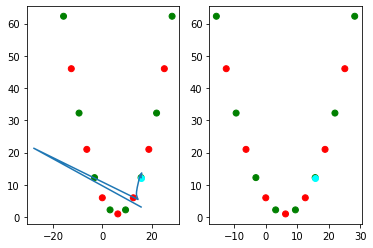

Distance to the closest point : 2.3377959739099516e-07 which is a Minimum

x0 :  [-1000, 1000]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in true_divide


The sequence diverged




In [ ]:
gammas = [0.1, 0.5, 1, 2, 5, 10]

b0 = np.eye(2)

for gamma in gammas :
    print("gamma : ", gamma)
    for x in x0:
        print("x0 : ", x)
        testSR1(x, gamma, b0, "const")
        print()
    print()

It looks like this modifyed SR1 works better than the original one for some values of $\gamma$, like here 0.5, where we have more convergence to global minimizers.
This is because since we are adding $\gamma I$ to $H_k$, the matrix becomes "more" positive definite, which helps to converge to a minimum.
But if we increase too much $\gamma$, $H_k$ approximates less and less the hessian of f, and so if $\gamma$ is too big we can lose the convergence, for example the sequence diverges for $x = (-1000, 1000)$ with  $\gamma = 2$. 

Exercise 2

In [ ]:
def f2(x):
  '''
  function to minimize
  x - array [x1,x2]
  '''
  x1 = x[0]
  x2 = x[1]
  return (x1 - 2) ** 4 + (x1 - 2*x2) ** 2

def c1(x):
  '''
  constaint function
  x - array [x1,x2]
  '''
  x1 = x[0]
  x2 = x[1]
  return x1 - x2**2

def L(xl):
  '''
  Lagrangian function of f
  xl - array [x1,x2,lam]
  '''
  x = np.array([xl[0],xl[1]])
  lam = xl[2]
  return f2(x) - lam * c1(x)

def Q(x,m):
  '''
  Quadratic penalty function of f
  x - array [x1,x2]
  m - penalty parameter (greater than 0)
  '''
  return f2(x) + 1/(2*m)*c1(x)**2

def Laug(x,lam,m):
  '''
  augumented Lagrangian function of f
  x - array [x1,x2]
  lam - lagrange multipliers
  m - penalty parameter
  '''
  return f2(x) - lam * c1(x) + 1/(2*m)*c1(x)**2

def e(k):
  '''
  non negative sequence converging to 0. Needed for the AL and QPM algorithms.
  k - k-th sequence element
  '''
  return 1/k


(a)

A local solution of a our Problem $x_*$, assuming that LICQ holds at $x_*$, fulfills the first order necessary condition, if there is a Lagrange multiplier $\lambda$ such that

$\nabla_x L(x_*,\lambda) = 0,$

and

$c_1(x_*) = 0$


are satisfied.

So we have to find solutions of the equations


1.   $\space 0 = 2(x_1 - 2x_2) + 4(x_1-2)^3 -\lambda$
2.   $\space 0 = 2x_2(\lambda + 4) - 4x_1$
3.   $\space 0 = x_2^2 - x_1$  $\implies$ $x_2^2 = x_1$

Inserting 3 in 2 we get

> $0 = 2x_2(\lambda + 4) - 4x_2^2 $
> $\implies 0 = 2x_2(\lambda + 4 - 2x_2) \quad(\star)$

First let $x_2 \neq 0 $. Then we have
> $\implies 0 = \lambda + 4 -2x_2 \implies x_2 = \frac{\lambda + 4}{2}$

Inserting 2 and 3 in 1 we get
> $ 0 = 2((\frac{\lambda + 4}{2})^2 - 2\frac{\lambda + 4}{2}) + 4((\frac{\lambda + 4}{2})^2-2)^3-\lambda$
> $\implies 0 = \frac{1}{16}\lambda^6 + \frac{3}{2}\lambda^5 + \frac{27}{2} \lambda^4 + 56 \lambda^3 + \frac{217}{2}\lambda^2 + 97 \lambda + 32$


Now we use np.roots to find the solution

In [ ]:
# parameters of the the polynomial function
p = [1/16,3/2,27/2,56,217/2,97,32]
np.roots(p)

array([-7.42049395+0.91856273j, -7.42049395-0.91856273j,
       -5.59918711+0.j        , -1.35969721+0.31202463j,
       -1.35969721-0.31202463j, -0.84043058+0.j        ])

This gives us $\lambda_1 \approx -5.59918711$ and $\lambda_2 \approx -0.84043058$.
Using the relations obtained before we have for $\lambda_1$
> $x_{1_2}^* = \frac{\lambda_1 + 4}{2} \approx -0.799593555$
> $\implies x_{1_1}^* = {x_{1_2}^*}^2 \approx 0.639349853$

and for $\lambda_2$
> $x_{2_2}^* = \frac{\lambda_2 + 4}{2} \approx 1.57978471$
> $\implies x_{1_1}^* = {x_{1_2}^*}^2 \approx 2.49571972.$

If we look at the case $x_2 = 0$ at $(\star)$, we have
> $\overset{3. \space eq.}\implies x_1 = 0$

> $\overset{1. \space eq.}\implies 0 = 2(0 - 2 \cdot 0) + 4(0-2)^3 -\lambda \implies \lambda = 32 $

So we have the KKT points 
> $x^*_1 = (0.639349853,−0.799593555), \lambda_1 =−5.59918711$

> $x^*_2 = (2.49571972,1.57978471),\lambda_2 = −0.84043058$

>$x^*_3 =(0,0), \lambda_3 = -32$

The gradient of the constraint function is given by 
> $\nabla c_1(x) = (1 \space \space-2x_2)^T$

and since this is never the zero vector LICQ is valid at all feasible points.

Now we take a look at the second order sufficent conditions. If $x^*$ is a feasable point with Lagrange multiplier $\lambda$ such that the KKT contodtions are satisfied. If $w^T\nabla^2_xL(x^*,\lambda)w>0, \quad \forall w \in C(x^*,\lambda)\setminus \{0\}$, then $x^*$ is a strict local soltution of our problem.

In [ ]:
# The KKT points [x1,x2,lambda]
k1 = [0.639349853,-0.799593555,-5.59918711]
k2 = [2.49571972,1.57978471,-0.84043058]
k3 = [0,0,-32]

def Ll(x, l):
  # Helper function to determine the Hessian wrt to x
  return L(np.append(x,l))

H = nd.Hessian(Ll)

We calculate the Hessian matrix for the KKT points:

In [ ]:
H1 = H(k1[0:2],k1[2])
print(H1)
print('Eigenvalues:')
print(np.linalg.eigh(H1)[0])

[[24.21642587 -4.        ]
 [-4.         -3.19837422]]
Eigenvalues:
[-3.77007835 24.78813   ]


In [ ]:
H2 = H(k2[0:2],k2[2])
print(H2)
print('Eigenvalues:')
print(np.linalg.eigh(H2)[0])

[[ 4.94885649 -4.        ]
 [-4.          6.31913884]]
Eigenvalues:
[1.57574454 9.69225079]


In [ ]:
H3 = H(k3[0:2],k3[2])
print(H3)
print('Eigenvalues:')
print(np.linalg.eigh(H3)[0])

[[ 50.  -4.]
 [ -4. -56.]]
Eigenvalues:
[-56.15072906  50.15072906]


Since $\nabla_x^2 L(x^*_2,\lambda_2)$ has stricly positive eigenvalues, the second order sufficent conditions are given in this case and $x_2^*$ is a strict local solution. For the others we take a look at the feasible directions and critical cones, since they are semi-positive definite. 

For $x_1^*$ and $\lambda_1$ we have the set of linearized feasible directions

> $F(x_1^*) = \{d \space |\space d^T\nabla c_1(x_1^*) = 0\} = \{d \space |\space d^T (1 \space \space -1.59918711)^T  = 0\} = \alpha \space (1.59918711 \space \space 1)^T, \quad \alpha \in \mathbb{R}$

and for $x_3^*$ and $\lambda_3$ it is given by

> $F(x_3^*) = \{d \space |\space d^T\nabla c_1(x_3^*) = 0\} = \{d \space | \space d^T(1 \space \space 0) = 0 \} = \alpha \space (0 \space \space 1)^T.$

We also have $C(x_1^*,\lambda_1) = F(x_1^*)$ and $C(x_3^*,\lambda_3) = F(x_3^*)$. Now we can take a look at weather these points fulfill the second order sufficent condotion.
We calculate

In [ ]:
w1 = np.array([1.59918711, 1])
w3 = np.array([0,1])


In [ ]:
w1.dot(H1).dot(w1)

45.93920220076932

Thus we have
> $w^T\nabla^2_xL(x_1^*,\lambda_1)w \approx 45.9392 \space \alpha ^2>0, \quad \forall w \in C(x_1^*,\lambda_1)\setminus \{0\}$

so the second order sufficent condition is satisfied at $x_1^*$ and it is a strict local solution.

In [ ]:
w3.dot(H3).dot(w3)

-56.0

Since we have 
> $w^T\nabla^2_xL(x_3^*,\lambda_3)w = -56 \space \alpha ^2 < 0, \quad \forall w \in C(x_3^*,\lambda_3)\setminus \{0\}$

the second order sufficent conditions are not satisfied.

Taking a look at the function values at the local solutions

In [ ]:
f2(k1[0:2])

8.438614251757533

In [ ]:
f2(k2[0:2])

0.5010836088847783

we know, that $x_2^*$ is the global and $x_1^*$ is a local solution.

(b)

In [ ]:
# KKT conditions Grad(L) = 0
gradL = nd.Gradient(L)

# choosing various starting points [x1,x2,lambda]
x0_1 = np.array([1, 1, 0])
x0_2 = np.array([-1, -1, 0])
x0_3 = np.array([0, 0, 0])

Using Newton to find the KKT points [$x1,x2, \lambda$]:

In [ ]:
def newton(func,x0,Jf=None,k=100,error=10**-8):
  '''
  newton root find
  func- function to root find
  x0- initial guess
  Jf- jacobian of func,if the jacobian of the function is not given (in the form of a function), it calculates it using nd
  k- maximum number of iterations
  error- margin error that if ||xk-xk-1||_2<error, it stops the algorithm
  '''
  if(Jf==None):
    Jf=nd.Jacobian(func)
  x=np.array(x0)
  for i in range(1,k+1):
      x_1=x
      y_aux=np.linalg.solve(Jf(x_1),(-1)*(np.array(func(x_1))))
      x=x_1+y_aux
      if(np.linalg.norm(x-x_1)<error):
          break
  return (x,i)
  

In [ ]:
KKT_1 = newton(func=gradL, x0=[1, 1, 0])
print("KKT point:")
print(KKT_1[0])
print(f'after {KKT_1[1]} iterations, with value f(x)={f2(KKT_1[0][0:2])}')

KKT point:
[ 2.49571973  1.57978471 -0.84043058]
after 13 iterations, with value f(x)=0.501083600522675


In [ ]:
KKT_2 = newton(func=gradL, x0=[-1, -1, 0])
print("KKT point:")
print(KKT_2[0])
print(f'after {KKT_2[1]} iterations, with value f(x)={f2(KKT_2[0][0:2])}')

KKT point:
[ 0.63934985 -0.79959356 -5.59918711]
after 7 iterations, with value f(x)=8.438614250651483


In [ ]:
KKT_3 = newton(func=gradL, x0=[0, 0, 0])
print("KKT point:")
print(KKT_3[0])
print(f'after {KKT_3[1]} iterations, with value f(x)={f2(KKT_3[0][0:2])}')

KKT point:
[  0.   0. -32.]
after 2 iterations, with value f(x)=16.0


Using Broyden to find KKT points:

In [ ]:
def broyden(func,x0,Ak=None,k=100,error=10**-8):
  '''
  broyden root find
  func- function to root find
  x0- initial guess
  ak-initial aproximation of the jacobian, if it is not given (in the form of a matrix), it calculates it using nd
  k- maximum number of iterations
  error- margin error that if ||xk-xk-1||_2<error, it stops the algorithm
  '''
  x=np.array(x0)
  if(Ak==None):
      Ak=nd.Jacobian(func)(x0)
  for i in range(1,k+1):
      x_1=x
      sk=np.linalg.solve(Ak,(-1)*(func(x_1)))
      x=x_1+sk
      if(np.linalg.norm(x-x_1)<error):
          break
      yk=func(x)-func(x_1)
      Ak=Ak+((1/(np.dot(sk,sk)))*(yk-Ak @ sk)) @ np.transpose(sk)
      
  return (x,i)

In [ ]:
KKT_1b = broyden(func=gradL, x0=[2.5,1.5,0])
print("KKT point:")
print(KKT_1b[0])
print(f'after {KKT_1b[1]} iterations, with value f(x)={f2(KKT_1b[0][0:2])}')

KKT point:
[ 2.49571973  1.57978471 -0.84043058]
after 26 iterations, with value f(x)=0.5010836002736355


In [ ]:
KKT_2b = broyden(func=gradL, x0=[1,-1,0.5])
print("KKT point:")
print(KKT_2b[0])
print(f'after {KKT_2b[1]} iterations, with value f(x)={f2(KKT_2b[0][0:2])}')

KKT point:
[ 0.63934985 -0.79959355 -5.59918713]
after 85 iterations, with value f(x)=8.438614244266642


In [ ]:
KKT_3b = broyden(func=gradL, x0=[0, 0, 0])
print("KKT point:")
print(KKT_3b[0])
print(f'after {KKT_3b[1]} iterations, with value f(x)={f2(KKT_3b[0][0:2])}')

KKT point:
[  0.   0. -32.]
after 2 iterations, with value f(x)=16.0


(c)

In [ ]:
# For (c) and (d) we need to do some slight adjustments to the BFGS and descent Algorithms
def wolf(func,xk,pk,alpha,df=None,c1=10**-4,c2=0.9):
  '''
  test the wolf conditions to a given step lenght

  func->function to test the wolf conditions
  xk-> current x
  pk-> current step direction
  alpha-> suggested step length
  c1,c2-> constants of the wolf conditions, if not imputed, it will assume the standart c1=10^-4, c2=0.9
  '''
  xk=np.array(xk)
  pk=np.array(pk)
  if(df==None):
    df=nd.Gradient(func)
  if(func(xk+alpha*pk)<= func(xk)+c1*alpha*np.dot(df(xk),pk)):
    if(np.dot(df(xk+alpha*pk),pk)>=c2*np.dot(df(xk),pk)):
      return True
  return False

def armijo(func,xk,pk,df=None,c1=10**-4,c2=0.9):
  '''
  returns a step length that respects the wolf conditions, using armijo rule
  '''
  alpha=1
  while(not wolf(func,xk,pk,alpha,df,c1,c2)):
    alpha=alpha/2
    if(alpha<10**-25):
      print("warning:No feasable step length the algorithm migth not be converging")
      return 1
  return alpha

def descent_exactQ(func,x0,df=None,k=100,error=10**-8):
  '''
  steepest descent with exact line search
  func- function to minimize
  x0- initial guess
  df<-grandient of the function(in the form of a fuction), if not given, it calculates it using nd
  k- maximum number of iterations
  error- margin error that if ||xk-xk-1||_2<error, it stops the algorithm
  func_aux<- auxiliar function to allow to use 1d minimization tools
  '''
  def func_aux(alpha,f,x_1,pk):
    return(f(x_1-alpha*pk))
  x=np.array(x0)
  if(df==None):
    df=nd.Gradient(func)
  for i in range(1,k+1):
    x_1=x
    x=x_1-sp.minimize_scalar(func_aux,args=(func,x_1,df(x_1))).x*df(x_1)
    #wasnt able to bound the minimizer to s>0
    # The stopping criterion has been adjusted
    if(np.linalg.norm(df(x))<error):
      break
  return x

def bfgs_wolfeQ(func,x0,df=None,Hk=None,k=100,error=10**-8):
  '''
  line search BFGS with step length deffined by the armijo rule
  test other constants in the armijo rule for the worlf conditions if the algo is stuck on a loop
  func- function to minimize
  x0- initial guess
  Hk-initial aproximation of the hessian, if it is not given (in the form of a matrix), it calculates it using nd
  df<-grandient of the function(in the form of a fuction), if not given, it calculates it using nd
  k- maximum number of iterations
  error- margin error that if ||xk-xk-1||_2<error, it stops the algorithm
  '''
  x=np.array(x0)
  if(Hk==None):
    Hk=nd.Hessian(func)(x0)
  if(df==None):
    df=nd.Gradient(func)
  for i in range(1,k+1):
    x_1=x
    pk=np.linalg.solve(Hk,(-1)*(df(x_1)))
    x=x_1+armijo(func,x_1,pk)*pk
    # The stopping criterion has been adjusted
    if(np.linalg.norm(df(x))<error):
      break
    sk=x-x_1
    yk=df(x)-df(x_1)
    Hk=Hk + np.outer(yk,yk)/(np.dot(yk,yk)) - Hk@np.outer(sk,sk)@Hk/np.dot(sk,Hk@sk)
  return x

In [ ]:
def QPM_descent(x0, m0, e=e, tol = 10 ** -4, iters = 15):
  '''
  quadratic penalty method, finds global minimum of f2
  x0 - starting point
  m0 - starting penalty parameter
  e - decreascing non negative sequence converging to 0
  tol - error tolerance
  iters - max number of iterations
  '''
  x_s = x0
  m_k = m0
  for k in range(1,iters):
    def Qm(x):
      # helper function so we can compute the Gradient of Q wrt x
      return Q(x,m=m_k)
    x = descent_exactQ(Qm, x0 = x_s, error=e(k))
    conv = 1/(2*m_k)*c1(x)**2
    if conv <= tol:
      break
    else:
      x_s = x
      m_k = m_k*0.5
  return (x,k)

def QPM_BFGS(x0, m0, e=e, tol = 10 ** -4, iters = 15):
  '''
  quadratic penalty method, finds global minimum of f2
  x0 - starting point
  m0 - starting penalty parameter
  e - decreascing non negative sequence converging to 0
  tol - error tolerance
  iters - max number of iterations
  '''
  x_s = x0
  m_k = m0
  for k in range(1,iters):
    def Qm(x):
      # helper function so we can compute the Gradient of Q wrt x
      return Q(x,m=m_k)
    x = bfgs_wolfeQ(func=Qm, x0 = x_s, error=e(k))
    conv = 1/(2*m_k)*c1(x)**2
    if conv <= tol:
      break
    else:
      x_s = x
      m_k = m_k*0.5
  return (x,k)

  

In [ ]:
min_BFGS = QPM_BFGS(x0=[2,1],m0 = 1)
print("Global minimum at:")
print(min_BFGS[0])
print(f'after {min_BFGS[1]} iterations, with value f(x) = {f2(min_BFGS[0])}')

Global minimum at:
[2.4956901 1.5797104]
after 13 iterations, with value f(x) = 0.5009112045974676


In [ ]:
min_descent = QPM_descent(x0=[2,1],m0=1)
print("Global minimum at:")
print(min_descent[0])
print(f'after {min_descent[1]} iterations, with value f(x) = {f2(min_descent[0])}')

Global minimum at:
[2.4687403  1.57115543]
after 13 iterations, with value f(x) = 0.5019730567890541


(d)

In [ ]:
def AL_BFGS(x0, m0, l0,e = e, tol = 10**-4, iters = 15):
  '''
  Augumented Lagrangian Method to find the global minimum of f2
  x0 - starting point
  m0 - starting penalty parameter
  l0 - lagrange multiplier
  e - decreascing non negative sequence converging to 0
  tol - error tolerance
  iters - max number of iterations
  '''
  x_s = x0
  m_k = m0
  l_k = l0
  for k in range(1,iters):
    def Laug_ml(x):
      return Laug(x = x, lam = l_k, m = m_k)
    x = bfgs_wolfeQ(func=Laug_ml, x0=x_s, error=e(k))
    conv = abs(c1(x))
    if conv <= tol:
      break
    else:
      l_k = l_k - c1(x)/m_k
      x_s = x
      m_k = m_k * 0.5
  return (x,k)

def AL_descent(x0, m0, l0,e = e, tol = 10**-4, iters = 15):
  '''
  Augumented Lagrangian Method to find the global minimum of f2
  x0 - starting point
  m0 - starting penalty parameter
  l0 - lagrange multiplier
  e - decreascing non negative sequence converging to 0
  tol - error tolerance
  iters - max number of iterations
  '''
  x_s = x0
  m_k = m0
  l_k = l0
  for k in range(1,iters):
    def Laug_ml(x):
      return Laug(x = x, lam = l_k, m = m_k)
    x = descent_exactQ(func=Laug_ml, x0=x_s, error=e(k))
    conv = abs(c1(x))
    if conv <= tol:
      break
    else:
      l_k = l_k - c1(x)/m_k
      x_s = x
      m_k = m_k * 0.5
  return (x,k)

In [ ]:
min_descent = AL_descent(x0=[0,0],m0=1, l0=1)
print("Global minimum at:")
print(min_descent[0])
print(f'after {min_descent[1]} iterations, with value f(x) = {f2(min_descent[0])}')

Global minimum at:
[2.47622657 1.57358313]
after 8 iterations, with value f(x) = 0.5015945716005252


In [ ]:
min_descent = AL_BFGS(x0=[2,1],m0=1, l0=1)
print("Global minimum at:")
print(min_descent[0])
print(f'after {min_descent[1]} iterations, with value f(x) = {f2(min_descent[0])}')

Global minimum at:
[2.49572107 1.57978223]
after 7 iterations, with value f(x) = 0.5010758757670919


Exercise 3

Exercise 3a)

\\

Given the linear function $F(x)=Ax-b , A\in {R}^{M \times N}, x \in{R}^{N \times 1}, b \in {R}^{M \times 1}$ with $rank(A)=N$, we can define the problem of linear least squares problem as $min_{x} f(x) = \frac{1}{2} F(x)^{T}F(x)$

\\

thus, we can define $f(x)$ as:
$f(x)=\frac{1}{2}((Ax-b)^{T}(Ax-b))=\frac{1}{2}((b-Ax)^{T}(b-Ax))= \frac{1}{2}(b^{T} b -x^{T}A^{T}b-b^{T}Ax + x^{T}A^{T}Ax)$

\\

Now, to find the minimum of the fucntion we compute the gradient:
$\frac{\partial f}{\partial x}=\frac{1}{2}( 0 -A^{T}b - (b^{T}A)^{T} + A^{T}Ax+ (A^{T}A)^{T}x)= \frac{1}{2}(-2A^{T}b + 2A^{T}Ax )=-A^{T}b + A^{T}Ax  $

\\

Now to calculate the point/s where the gradient is equal to 0

$ \frac{\partial f}{\partial x}= 0  \Leftrightarrow -A^{T}b + A^{T}Ax=0 

\Leftrightarrow x= (A^{T}A)^{-1}A^{T}b $ 

Thus we prove that $\hat x=(A^{T}A)^{-1}A^{T}b$ is the only stationary point.

\\

$\frac {\partial^{2}f} { \partial x \partial x^{T} }= \frac {\partial} { \partial x }(\frac{\partial f}{\partial x^{T}})=\frac{\partial} { \partial x }(\frac{\partial f}{\partial x})^{T} = \frac{\partial}{ \partial x }(A^{T}Ax + A^{T}Ax )=0+ A^{T}A$

\\

It's trivial to see that if $rank(A)=N$ (which it is) ,$A^{T}A$ is positive definite matrix, thus the hessian of the function is positive definite for all x, implying  that $\hat x$ is a global minimum of the function.

\\

Now we can test the results that the gauss newton algorithm gives in this specific problem.This algorithm can defined as:

Pure Gauss-Newton Algorithm:

\\

Choose $x_{0} \in R^{N}$. For k=0,1,...:

\\

1. Solve the linear system: $J_{F}(x_{K})^{T}J_{F}(x_{K})p_{k}=-J_{F}(x_{K})^{t}F(X_{k})$

\\

2. Compute: $x_{k+1}=x_{k}+p_{k}$

\\

Now replacing with the values of the problem:

\\

1. $J_{F}(x_{K})^{T}J_{F}(x_{K})p_{k}=-J_{F}(x_{K})^{t}F(X_{k}) \Leftrightarrow   A^{T}A p_{k}= A^{T}(-Ax_{k}+b) \Leftrightarrow pk=(A^{T}A)^{-1} A^{T}(-Ax_{k}+b)  \Leftrightarrow pk=-x_{k}+(A^{T}A)^{-1}A^{T}b$

\\

2. $x_{k+1}=x_{k}+p_{k}=x_{k}-x_{k}+(A^{T}A)^{-1}A^{T}b=(A^{T}A)^{-1}A^{T}b$

\\

Thus we can conclude that for any $x_{0} \in R^{N}$, $x_{1}=(A^{T}A)^{-1}A^{T}b$ which is the global minimum of the function, proving that the gauss newton algorithm solves the linear least squares problem in one iteration.








Exercise 3b):

\\

The newton algorithm can be described as:

\\

Choose $x_{0} \in R^{N}$. For k=0,1,...:

\\

1. Solve the linear system: $(J_{F}(x_{K})^{T}J_{F}(x_{K})+ S(X_{k}))p_{k}=-J_{F}(x_{K})^{T}F(X_{k})$
where $S(X)=\sum^{M}_{j=1}f_{j}(x) H_{f_{j}}(x)$

\\

2. Compute: $x_{k+1}=x_{k}+p_{k}$

\\

Pure Gauss-Newton Algorithm:

Choose $x_{0} \in R^{N}$. For $k=0,1,...$:

\\

1. Solve the linear system: $J_{F}(x_{K})^{T}J_{F}(x_{K})p_{k}=-J_{F}(x_{K})^{T}F(X_{k})$

\\

2. Compute: $x_{k+1}=x_{k}+p_{k}$

\\

In the next few windows we will declare the objective function, both algorithms and some auxliary functions



In [ ]:
#declaration of the objective function
t=np.array([0.2,0.5,1,1.5])
y=np.array([0.9,0.6,-0.6,-0.7])

x0=np.array([20,20])
def f(x):
  return np.sin(t*x[0])+np.cos(t*x[1])-y

def F(x):
  return 0.5*np.dot(f(x),f(x))

In [ ]:
#fucntion to help plot results of the algorithms
def plot(x):
  t_aux=np.linspace(0, 2, 20000, endpoint=True)
  def f_aux(t):
    return np.sin(t*x[0])+np.cos(t*x[1])
  fig = plt.figure()
  plt.grid(True)
  ax = plt.axes()
  ax.plot(t_aux,f_aux(t_aux))
  ax.plot(t,y, 'ro')
  ax.set_xlabel('t')
  ax.set_ylabel('y')
  plt.draw()


In [ ]:
def newton_nlls(func,x0,k=100,error=10**-8,Testing=False):
  '''
  newton nlls
  the function has already the constants (y and t) defined outside the scope of the fuction and its not an object of the function
  k- maximum number of iterations
  error- margin error that if ||xk-xk-1||_2<error, it stops the algorithm
  Testing: print warning mensages if the hessian is not definite positive
  '''
  index=len(func(x0))
  
  def J(x):
    return np.transpose(nd.Jacobian(func)(x)) @ nd.Jacobian(func)(x)

  def fj(x,i):
    return np.array((func(x))[i])
  def S(x):
    aux=np.zeros((len(x),len(x)))
    for j in range(0,index):
      aux =  aux + fj(x,j) * nd.Hessian(fj)(x,j)
    return aux
  def df(x):
    return np.transpose(nd.Jacobian(func)(x) )  @ func(x)
  aux=[]
  x=np.array(x0)
  for i in range(1,k+1):
      x_1=x
      y_aux=np.linalg.solve( J(x_1)+S(x_1)  ,(-1)*df(x_1)  )
      x=x_1+y_aux
      aux.append((x,i))
      if(Testing):
        if(any(eigen<=0 for eigen in np.linalg.eigvals(J(x_1)+S(x_1)))):
          print(f"iter {i} Newton:The algorithm migth not be converging: The hessian is not definite positive")
          Testing=False
      if(np.linalg.norm(x-x_1)<error):
          break
      
  return aux


In [ ]:
def gauss_newton_nlls(func,x0,k=100,error=10**-8,Testing=False):
  '''
  gauss_newton nlls
  k- maximum number of iterations
  error- margin error that if ||xk-xk-1||_2<error, it stops the algorithm
  Testing: print warning mensages if the hessian is not definite positive
  '''
  aux=[]
  def J(x):
    return np.transpose(nd.Jacobian(func)(x)) @ nd.Jacobian(func)(x)

  def df(x):
    return np.transpose(nd.Jacobian(func)(x) )  @func(x)
  
  x=np.array(x0)
  for i in range(1,k+1):
      x_1=x
      y_aux=np.linalg.solve( J(x_1)  ,(-1)*df(x_1)  )
      x=x_1+y_aux
      aux.append((x,i))

      if(Testing):
        if(any(eigen<=0 for eigen in np.linalg.eigvals(J(x_1)))):
          print(f"iter {i} Gauss_newton:The algorithm migth not be converging: The hessian is not definite positive")
          Testing=False
          
      if(np.linalg.norm(x-x_1)<error):
          break
      
  return aux

In order to find the global minimum we'll try these algorithms with various initial approximations.

\\

The proceadure that we'll use consists of:

\\

For every initial approximation:

\\

1. Run both newton and Gauss newton on the declared initial approximation

\\

2. While the algorithm is running, check if the hessian(or the approximation of the hessian) is definite positive.

\\

3. While the algorithm is running, check if there are any numerical problems (in this particular case, singular hessians)

\\

4. Check the solution given by both algorithms (if it was computed) and the value of the objective function


In [ ]:
initial_guesses=[[0,0],[1,1],[-1,-1],[0,3],[3,0],[1,2],[2,1],[1,-3],[-3,1],[10,1],[1,10],[20,20]]
for i in initial_guesses:
  try:
    print(f"initial guess: {i} ")
    results1=newton_nlls(f,i,Testing=True)[-1][0]
    results2=gauss_newton_nlls(f,i,Testing=True)[-1][0]
    print(f"Newton: x:{results1} F:{F(results1)}")
    print(f"Gauss Newton: x:{results2} F:{F(results2)}")
    print("")
  except:
    print(f">Singular matrix, no convergence")

    print("")

initial guess: [0, 0] 
iter 1 Newton:The algorithm migth not be converging: The hessian is not definite positive
>Singular matrix, no convergence

initial guess: [1, 1] 
iter 1 Newton:The algorithm migth not be converging: The hessian is not definite positive
Newton: x:[1.09106618 4.44106441] F:4.430671272823719
Gauss Newton: x:[0.15620817 2.32589044] F:0.010665033355154402

initial guess: [-1, -1] 
iter 3 Newton:The algorithm migth not be converging: The hessian is not definite positive
Newton: x:[-3.22622567 -4.43204861] F:6.330233911492449
Gauss Newton: x:[-1.17265081 -0.92960186] F:0.08873617592947255

initial guess: [0, 3] 
Newton: x:[0.15620817 2.32589044] F:0.010665033355154388
Gauss Newton: x:[0.15620817 2.32589044] F:0.010665033355154405

initial guess: [3, 0] 
iter 1 Newton:The algorithm migth not be converging: The hessian is not definite positive
>Singular matrix, no convergence

initial guess: [1, 2] 
iter 1 Newton:The algorithm migth not be converging: The hessian is not 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


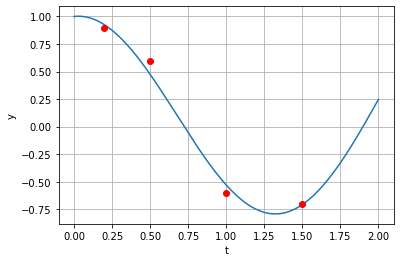

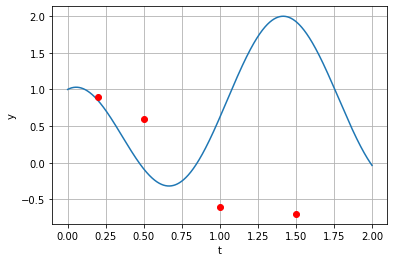

In [ ]:
plot(gauss_newton_nlls(f,[1,1])[-1][0])
plot(newton_nlls(f,[1,1])[-1][0])

Some observations:

\\

- The global minimum of $\frac{1}{2}F^{T}(x^{*})
F(x^{*})$ appears to be 0.01067 where  [x1,x2]=[0.1562, 2.3258 ]

\\

- In most inititial approximations the Newton algorithm does not converge to the global minimum.

\\

- Both algorithms are very sensible to the initial approximation, not converging to the global minimum if the initial approximation is not close to this minimum.

\\

- Some initial approximations cause numerical problems (Singular Hessians).

\\

- Of the initial approximations tested, the one that doent cause convergence or numerial problems in both methods is [0, 3].

Exercise 3 c):




In order to estimate the rate of convergence , we ll use the formula:
$r\approx \frac{ln(||x^{*}-x^{(n+2)}||/||x^{*}-x^{(n+1)}||}{ln(||x^{*}-x^{(n+1)}||/||x^{*}-x^{(n)}||}$

\\

It is important to mention that we ll consider the "real" soltution as the last solution given by the algorithm before stopping.

\\

We will also record the time used and the number of iterations used by each algorithm to reach a certain error margin.


In [ ]:
x0=[0,3]
time1=time.perf_counter()
results1=newton_nlls(f,x0,error=10**-8)
time2=time.perf_counter()

r1=[]
for i in range(0,len(results1)-3):
  aux1=np.log(np.linalg.norm(results1[-1][0]-results1[i+2][0])/np.linalg.norm(results1[-1][0]-results1[i+1][0]))
  aux2=np.log(np.linalg.norm(results1[-1][0]-results1[i+1][0])/np.linalg.norm(results1[-1][0]-results1[i][0]))
  r1.append(aux1/aux2)


print("Newton: ",round(time2-time1,4),"seconds")
print("Newton: number of iterations:",results1[-1][1])
print(f"Newton: rate of Convergence:{r1}")

time3=time.perf_counter()
results2=gauss_newton_nlls(f,x0,error=10**-8)
time4=time.perf_counter()
print("")
r2=[]
for i in range(0,len(results2)-3):
  aux1=np.log(np.linalg.norm(results2[-1][0]-results2[i+2][0])/np.linalg.norm(results2[-1][0]-results2[i+1][0]))
  aux2=np.log(np.linalg.norm(results2[-1][0]-results2[i+1][0])/np.linalg.norm(results2[-1][0]-results2[i][0]))
  r2.append(aux1/aux2)

print("Gauss Newton: ",round(time4-time3,4),"seconds")
print("Gauss Newton: number of iterations:",results2[-1][1])
print(f"Gauss Newton: rate of Convergence:{r2}")



Newton:  0.2271 seconds
Newton: number of iterations: 7
Newton: rate of Convergence:[1.468791848780496, 2.315081387782988, 1.9106715328223036, 2.118385827970467]

Gauss Newton:  0.121 seconds
Gauss Newton: number of iterations: 8
Gauss Newton: rate of Convergence:[1.1801532066267855, 0.8844095471545453, 0.9987049368381589, 1.0007448171715847, 0.9855947803737]


We can conclude then that the Newton algorithm converges quadratically, and the gauss newton algorithm converges linearly.

\\

But is also important to mention that the gauss newton is faster than the newton algorithm to reach the same error rate, even though it uses more iterations.

\\

This can be explain by the computational complexity of computing S(x) in the newton algorithm.

Exercise 3 d)

In order to make an a line search Gauss-Newton method with inexact search of the step length we decided to use an armijo backtractracking rule to find a feasable step size.

In [ ]:
def wolf(func,xk,pk,alpha,df=None,c1=10**-4,c2=0.9):
  '''
  test the wolf conditions to a given step lenght

  func->function to test the wolf conditions
  xk-> current x
  pk-> current step direction
  alpha-> suggested step length
  c1,c2-> constants of the wolf conditions, if not imputed, it will assume the standart c1=10^-4, c2=0.9
  '''
  xk=np.array(xk)
  pk=np.array(pk)
  if(df==None):
    df=nd.Gradient(func)
  if(func(xk+alpha*pk)<= func(xk)+c1*alpha*np.dot(df(xk),pk)):
    if(np.dot(df(xk+alpha*pk),pk)>=c2*np.dot(df(xk),pk)):
      return True
  return False

def armijo(func,xk,pk,df,c1=10**-4,c2=0.9):
  '''
  returns a step length that respects the wolf conditions, using armijo rule

  '''
  alpha=1
  while(not wolf(func,xk,pk,alpha,df,c1,c2)):
    alpha=alpha/2
    if(alpha<10**-25):
      print("warning:No feasable step length the algorithm migth not be converging")
      return 1
  return alpha




def ls_gauss_newton_nlls(func,x0,k=100,error=10**-8,Testing=False):
  '''
  gauss newton nlls w/ line search
  k- maximum number of iterations
  error- margin error that if ||xk-xk-1||_2<error, it stops the algorithm
  Testing: print warning mensages if the hessian is not definite positive
  '''
  def Faux(x):
    return 0.5*np.transpose(func(x))@func(x)
  def J(x):
    return np.transpose(nd.Jacobian(func)(x)) @ nd.Jacobian(func)(x)
  def df(x):
    return np.transpose(nd.Jacobian(func)(x) )  @f(x)

  x=np.array(x0)
  aux=[]
  for i in range(1,k+1):
      x_1=x
      y_aux=np.linalg.solve( J(x_1)  ,(-1)*df(x_1)  )

      x=x_1+armijo(Faux,x_1,y_aux,df=df)*y_aux

      if(Testing):
        if(any(eigen<=0 for eigen in np.linalg.eigvals(J(x_1)))):
          print(f"iter {i} Gauss_newton:The algorithm migth not be converging: The hessian is not definite positive")
          Testing=False

      aux.append((x,i))

      if(np.linalg.norm(x-x_1)<error):
          break
  return aux



In [ ]:
initial_guesses=[[1,1],[0.7,0.2],[0.2,0.7],[-1,-1],[0,3],[3,0],[1,2],[2,1]]
for i in initial_guesses:
  try:
    print(f"initial guess: {i} ")
    time1=time.perf_counter()
    results1=gauss_newton_nlls(f,i,error=10**-8)
    time2=time.perf_counter()
    print(f"gauss_newton: F({i})= ",F(results1[-1][0]))
    print("gauss_newton: ",round(time2-time1,4),"seconds")
    print("gauss_newton: number of iterations:",results1[-1][1])

    time3=time.perf_counter()
    results2=ls_gauss_newton_nlls(f,i,error=10**-8)
    time4=time.perf_counter()
    print(f"ls_gauss_newton: F({i})= ",F(results2[-1][0]))
    print("ls_gauss_newton: ",round(time4-time3,4),"seconds")
    print("ls_gauss_newton: number of iterations:",results2[-1][1])
    print("")
  except:
    print("Singular matrix, no convergence")

    print("")

initial guess: [1, 1] 
gauss_newton: F([1, 1])=  0.010665033355154402
gauss_newton:  0.1259 seconds
gauss_newton: number of iterations: 9
ls_gauss_newton: F([1, 1])=  0.010665033355154393
ls_gauss_newton:  0.2381 seconds
ls_gauss_newton: number of iterations: 9

initial guess: [0.7, 0.2] 
gauss_newton: F([0.7, 0.2])=  0.135339892002393
gauss_newton:  0.215 seconds
gauss_newton: number of iterations: 16
ls_gauss_newton: F([0.7, 0.2])=  0.010665033355154405
ls_gauss_newton:  1.222 seconds
ls_gauss_newton: number of iterations: 10

initial guess: [0.2, 0.7] 
gauss_newton: F([0.2, 0.7])=  0.08873617592947251
gauss_newton:  0.1131 seconds
gauss_newton: number of iterations: 9
ls_gauss_newton: F([0.2, 0.7])=  0.08873617592947251
ls_gauss_newton:  0.2319 seconds
ls_gauss_newton: number of iterations: 9

initial guess: [-1, -1] 
gauss_newton: F([-1, -1])=  0.08873617592947255
gauss_newton:  0.092 seconds
gauss_newton: number of iterations: 7
ls_gauss_newton: F([-1, -1])=  0.08873617592947255
l

The results are quite mixed. For exemple, the initial approximation [1,2] the line gauss newton converges to a worse solutuion, and for the initial approximation [0.7, 0.2] it converges to a better solution that the pure gauss newton method. 

\\

But for all the initial approximations tested, the line search gauss newton method takes at least double the time of the pure gauss newton method.

\\

This make us conclude that the line search gauss newton, although it has better theoretial proprieties, in this specific problem it does not work properly because, the initial approximation has to be already close to the minimum, for it to converge.

